# NDIS Staggered Decision - CPM+RF

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

In [ ]:
%matplotlib inline
#ArcGIS packages
import arcpy
#from arcgis.mapping import WebScene
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from IPython.display import display
from arcgis.features import GeoAccessor
from arcgis import *
from arcpy.sa import Raster, Int  # Raster float to integer
# Raster processing for dataframe
from rasterstats import zonal_stats

# basic packages
import csv
import numpy as np
import os
import timeit
import random
import string
from pprint import pprint

# Data management
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  # to get points from long lat
import gc
import shutil
import tempfile
import ast
from collections import Counter
from typing import Optional, List

# Request service
#from requests import Request
import json
import re
from functools import reduce
#from owslib.wfs import WebFeatureService

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import warnings
import multiprocessing
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# To save the model and everything else to be API ready
import joblib
import pickle

In [ ]:
# Set the path to this geodatabase
gdb_path = r"D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb"  # This gdb path
arcpy.env.overwriteOutput = True

In [ ]:
# Load geohazard dataset
geohazard_df = pd.read_csv(r"D:\NDIS_Database\ghz_rf_cpm.csv")
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
 15  selected_drone         object 
 16  drone_speed            float64
 17  drone_flight_time      float64
 18  travel_time            float64
 19  monitor_time           float64
 20  cpm_total_time         float64
dtypes: float64(12), int64(5), object(4)
memory usage: 290.

In [ ]:
# Extract useful field/column for staggered decision
columns_to_drop = [
    'selected_sensor',
    'sensor_id',
    'parameters',
    'sensor_name',
    's_encoded',
    'sensor_weight',
    'selected_drone',
    'drone_speed',
    'drone_flight_time'
]

ghz_sd = geohazard_df.drop(columns=columns_to_drop)
ghz_sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  drone_sensor_combo     object 
dtypes: float64(10), int64(2), object(1)
memory usage: 180.0+ MB


In [ ]:
# Function to obtain "HazardStage" --> "pre_event", "active", "dormant", "aftershock", "triggered", "post_event"
def infer_stage(row):
    ht = row["HazardType"]
    intensity = row["intensity"]
    duration = row["duration_minutes"]

    if ht == "Fault":
        return "pre_event"
    elif ht == "Earthquake":
        if intensity >= 6:
            return "during"
        elif 4 <= intensity < 6:
            return "aftershock"
        else:
            return "pre_event"
    elif ht == "Volcano":
        if intensity >= 4 or duration > 120:
            return "during"
        elif 1.5 <= intensity < 4:
            return "pre_event"
        elif duration <= 60:
            return "dormant"
        else:
            return "clean_up"
    elif ht == "Landslide":
        if duration < 60:
            return "during"
        elif 60 <= duration < 180:
            return "post_event"
        else:
            return "pre_event"
    elif ht == "Tsunami":
        if duration <= 60:
            return "during"
        elif 60 < duration <= 240:
            return "post_event"
        else:
            return "clean_up"
    else:
        return "unknown"

In [ ]:
ghz_sd["HazardStage"] = ghz_sd.apply(infer_stage, axis=1)
ghz_sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
dtypes: float64(10), int64(2), object(1)
memory usage: 180.0+ MB


In [ ]:
hazard_mapping = {
    1: "Volcano",
    2: "Landslide",
    3: "Tsunami",
    4: "Fault",
    5: "Earthquake"
}

ghz_sd["HazardType"] = ghz_sd["HazardType"].map(hazard_mapping)

In [ ]:
# Vectorized Version if the "apply" method take too long
start_time = timeit.default_timer()

haz = ghz_sd["HazardType"]
intensity = ghz_sd["intensity"].fillna(0)
duration = ghz_sd["duration_minutes"].fillna(0)

# Fault
cond_fault = (haz == "Fault")

# Earthquake: 0.1–5 min typical
cond_eq_during = (haz == "Earthquake") & (duration <= 5)
cond_eq_post = (haz == "Earthquake") & (duration > 5)

# Volcano: days to months
cond_volc_during = (haz == "Volcano") & (duration >= 1440)  # 1 day+
cond_volc_pre = (haz == "Volcano") & (intensity <= 2) & (duration < 1440)
cond_volc_dormant = (haz == "Volcano") & (intensity < 1.5) & (duration < 60)
cond_volc_cleanup = (haz == "Volcano") & (intensity <= 3) & (duration >= 2880)  # 2+ days

# Landslide: 10 min – 3 days
cond_ls_during = (haz == "Landslide") & (duration <= 180)       # <= 3 hours
cond_ls_post = (haz == "Landslide") & (duration > 180) & (duration <= 4320)  # <= 3 days
cond_ls_cleanup = (haz == "Landslide") & (duration > 4320)

# Tsunami: 10–360 min typical
cond_ts_during = (haz == "Tsunami") & (duration <= 240)
cond_ts_post = (haz == "Tsunami") & (duration > 240) & (duration <= 720)
cond_ts_cleanup = (haz == "Tsunami") & (duration > 720)

conditions = [
    cond_fault,
    cond_eq_during, cond_eq_post,
    cond_volc_during, cond_volc_pre, cond_volc_dormant, cond_volc_cleanup,
    cond_ls_during, cond_ls_post, cond_ls_cleanup,
    cond_ts_during, cond_ts_post, cond_ts_cleanup
]

choices = [
    "pre_event",        # Fault
    "during", "post_event",           # Earthquake
    "during", "pre_event", "dormant", "clean_up",  # Volcano
    "during", "post_event", "clean_up",            # Landslide
    "during", "post_event", "clean_up"             # Tsunami
]

# Apply vectorized selection
ghz_sd["HazardStage"] = np.select(conditions, choices, default="unknown")


elapsed = timeit.default_timer() - start_time
print("\u2705 RF Training completed! Elapsed time: %s minutes" % str(elapsed / 60))

✅ RF Training completed! Elapsed time: 0.06645213833326125 minutes


In [ ]:
ghz_sd

,HazardID,latitude,longitude,HazardType,distance,pop,intensity,duration_minutes,economic_loss_million,travel_time,monitor_time,cpm_total_time,drone_sensor_combo,HazardStage
0,210010,50.170000,6.850000,Volcano,34.462092,1.346558e+05,2.0,1510.00,2.82,3.83,1510.00,1513.83,IDEAFLY Poseidon-480 Pro II + Seismic,during
1,210020,45.775000,2.970000,Volcano,1068.063073,4.145101e+05,3.0,9376.00,9.86,118.67,9376.00,9494.67,IDEAFLY Thor-850 + Seismic,during
2,210030,42.170000,2.530000,Volcano,1798.388196,1.461354e+05,1.0,33.00,0.51,199.82,33.00,232.82,IDEAFLY Thor-850 + Seismic,pre_event
3,210040,38.870000,-4.020000,Volcano,547.012635,1.739199e+05,2.0,1672.00,2.62,60.78,1672.00,1732.78,IDEAFLY Poseidon-480 Pro II + Seismic,during
4,211004,41.730000,12.700000,Volcano,183.805721,2.411999e+06,1.0,151.00,0.99,20.42,151.00,171.42,IDEAFLY Poseidon-480 Pro II + Seismic,pre_event
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814694,1779999762,7.532258,-77.758715,Fault,55485.569192,7.768821e+03,1.0,90.05,0.01,2920.29,90.05,3010.34,Drone America Savant + Seismic,pre_event
1814695,1779999849,6.942987,-77.639198,Fault,61702.289243,4.558220e+03,1.0,74.97,0.01,3247.49,74.97,3322.46,Drone America Savant + Seismic,pre_event
1814696,1779999872,9.248675,-78.994425,Fault,1317.387302,5.720637e+04,1.0,70.05,0.02,146.38,70.05,216.43,IDEAFLY Thor-850 + Seismic,pre_event
1814697,1779999875,9.224729,-78.860133,Fault,692.425627,3.482288e+04,1.0,153.32,0.04,76.94,153.32,230.26,IDEAFLY Poseidon-480 Pro II + Seismic,pre_event


In [ ]:
print(ghz_sd['HazardStage'].unique())

['during' 'pre_event' 'post_event']


In [ ]:
ghz_sd.to_csv(r"D:\NDIS_Database\ghz_sd.csv", index=False)

# NEW ENTRY NUCLEAR ☢️
power plant

In [ ]:
# Read data
nuclear_df = pd.read_csv(r"D:\NDIS_Database\15_NuclearPower\nuclearpp.csv")
nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 38 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date Last Researched                      1541 non-null   object 
 1   Country/Area                              1541 non-null   object 
 2   Project Name                              1541 non-null   object 
 3   Unit Name                                 1541 non-null   object 
 4   Project Name in Local Language / Script   361 non-null    object 
 5   Other Name(s)                             333 non-null    object 
 6   Capacity (MW)                             1541 non-null   object 
 7   Status                                    1541 non-null   object 
 8   Reactor Type                              1541 non-null   object 
 9   Model                                     1541 non-null   object 
 10  Start Year                          

In [ ]:
nuclear_df['Owner'].unique()

array(['Nucleoelectrica Argentina SA', 'China National Nuclear CORP',
       'Comision Nacional De Energia Atomica',
       'Ministry Of Territorial Administration And Infrastructure', nan,
       'Bangladesh Atomic Energy Commission',
       'Republican Unitary Enterprise "Belarusian Nuclear Power Plant"',
       "Centre D'Etude De L'Energie Nucleaire; Studiecentrum Voor Kernenergie",
       'Indivision Doel',
       "Societes Reunies D'Energie Du Bassin De L'Escaut SA",
       'Engie Electrabel', 'Eletrobras Eletronuclear SA',
       'DP RAO (State Enterprise “Radio Active Waste”)',
       'Bulgarian Energy Holding CO',
       'Capital Power Corp; Ontario Power Generation Inc',
       'Ontario Power Generation', 'Global First Power Ltd',
       'Atomic Energy Of Canada LTD', 'Canadian Nuclear Laboratories LTD',
       'Hydro Quebec', 'AECL', 'New Brunswick Electric Power Commission',
       'Prodigy Clean Energy; Des Nëdhé Group',
       'Institute of Nuclear and New Energy Technolog

In [ ]:
nuclear_stat = nuclear_df[['GEM unit ID','Project Name', 'Longitude', 'Latitude', 'Capacity (MW)', 'Country/Area', 'Owner', 'Status', 'Reactor Type', 'Wiki URL']].copy()
nuclear_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GEM unit ID    1541 non-null   object 
 1   Project Name   1541 non-null   object 
 2   Longitude      1541 non-null   float64
 3   Latitude       1541 non-null   float64
 4   Capacity (MW)  1541 non-null   object 
 5   Country/Area   1541 non-null   object 
 6   Owner          1372 non-null   object 
 7   Status         1541 non-null   object 
 8   Reactor Type   1541 non-null   object 
 9   Wiki URL       1541 non-null   object 
dtypes: float64(2), object(8)
memory usage: 120.5+ KB


In [ ]:
nuclear_stat.to_csv(r"D:\NDIS_Database\13_NDIS_Display\Page3\nuclear_stat.csv", index=False)

## Economic loss:
based on https://thecostguys.com/business/build-nuclear-power-plant and https://en.wikipedia.org/wiki/Economics_of_nuclear_power_plants#Construction_costs

In [ ]:
# Clean numeric Capacity
nuclear_df["Capacity (MW)"] = pd.to_numeric(nuclear_df["Capacity (MW)"], errors="coerce").fillna(0)

# Extract numeric ID from GEM unit ID
gem_id_numeric = nuclear_df["GEM unit ID"].astype(str).str.extract(r"(\d+)$")[0]
hazard_id = "111" + gem_id_numeric
hazard_id = hazard_id.astype("int64")

# Assemble the cleaned nuclear hazard dataframe
cleaned_nuclear_df = pd.DataFrame({
    "HazardID": hazard_id,
    "latitude": pd.to_numeric(nuclear_df["Latitude"], errors="coerce"),
    "longitude": pd.to_numeric(nuclear_df["Longitude"], errors="coerce"),
    "HazardType": "Nuclear",
    "distance": np.nan,                 # To be filled by spatial ops
    "pop": np.nan,                      # To be filled by ArcGIS later
    "intensity": 5.0,                   # Default high severity
    "duration_minutes": 1440.0,         # 1 day
    "economic_loss_million": nuclear_df["Capacity (MW)"] * 11.5,  # $11.5M per MW
    "travel_time": np.nan,
    "monitor_time": 120.0,              # Default 2 hours
    "cpm_total_time": np.nan,
    "HazardStage": "pre_event"
})

cleaned_nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   distance               0 non-null      float64
 5   pop                    0 non-null      float64
 6   intensity              1541 non-null   float64
 7   duration_minutes       1541 non-null   float64
 8   economic_loss_million  1541 non-null   float64
 9   travel_time            0 non-null      float64
 10  monitor_time           1541 non-null   float64
 11  cpm_total_time         0 non-null      float64
 12  HazardStage            1541 non-null   object 
dtypes: float64(10), int64(1), object(2)
memory usage: 156.6+ KB


In [ ]:
start_time = timeit.default_timer()
# Parameters
layer_name = "nuclearpp" # Feature class
# Use geopandas to read it
input_gdf = gpd.read_file(gdb_path, layer=layer_name)
population_raster = r"D:\NDIS_Database\12_Population_synthetic\nasapopct.tif"
buffer_dist = 30000  # 30km
chunk_size = 100
std_threshold = 10

# Load input as GeoDataFrame
#gdf = gpd.read_file(input_fc)

# Reproject to WGS84 (EPSG:4326) if needed
if input_gdf.crs.to_epsg() != 4326:
    input_gdf = input_gdf.to_crs(epsg=4326)

# Calculate approximate buffer distance in degrees
buffer_deg = buffer_dist / 111320.0  # 1 degree ≈ 111.32 km at equator

# Final results
final_chunks = []

total = len(input_gdf)
print(f"Total features: {total}")

for start in range(0, total, chunk_size):
    print(f"\u23F3 Processing chunk {start+1} to {min(start + chunk_size, total)}")

    chunk = input_gdf.iloc[start:start + chunk_size].copy()

    # Suppress geographic CRS buffer warning
    warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*")
    chunk["geometry"] = chunk.geometry.buffer(buffer_deg)

    # Zonal statistics
    stats = zonal_stats(chunk, population_raster,
                        stats=["mean", "majority", "count", "std"],
                        geojson_out=False)

    # Smart pop estimation
    smart_pops = []
    for row in stats:
        count = row.get("count", 0) or 0
        mean = row.get("mean", 0) or 0
        majority = row.get("majority", 0) or 0
        std = row.get("std", 0) or 0

        if count == 0:
            pop = 0
        elif std < std_threshold:
            pop = majority * count
        else:
            pop = mean * count

        smart_pops.append(pop)

    chunk["pop"] = smart_pops
    final_chunks.append(chunk)

    print(f"\u2705 Chunk {start+1} processed.")

# Combine all results
nuclear_gdf = pd.concat(final_chunks, ignore_index=True)

# Optional: export to CSV
# final_gdf.drop(columns="geometry").to_csv("smart_population_estimate.csv", index=False)
elapsed = timeit.default_timer() - start_time
print("\u2705 All done. Result in dataframe: nuclear_gdf. Elapsed time: %s minutes" % str(elapsed / 60))

Total features: 1541
⏳ Processing chunk 1 to 100
✅ Chunk 1 processed.
⏳ Processing chunk 101 to 200
✅ Chunk 101 processed.
⏳ Processing chunk 201 to 300
✅ Chunk 201 processed.
⏳ Processing chunk 301 to 400
✅ Chunk 301 processed.
⏳ Processing chunk 401 to 500
✅ Chunk 401 processed.
⏳ Processing chunk 501 to 600
✅ Chunk 501 processed.
⏳ Processing chunk 601 to 700
✅ Chunk 601 processed.
⏳ Processing chunk 701 to 800
✅ Chunk 701 processed.
⏳ Processing chunk 801 to 900
✅ Chunk 801 processed.
⏳ Processing chunk 901 to 1000
✅ Chunk 901 processed.
⏳ Processing chunk 1001 to 1100
✅ Chunk 1001 processed.
⏳ Processing chunk 1101 to 1200
✅ Chunk 1101 processed.
⏳ Processing chunk 1201 to 1300
✅ Chunk 1201 processed.
⏳ Processing chunk 1301 to 1400
✅ Chunk 1301 processed.
⏳ Processing chunk 1401 to 1500
✅ Chunk 1401 processed.
⏳ Processing chunk 1501 to 1541
✅ Chunk 1501 processed.
✅ All done. Result in dataframe: nuclear_gdf. Elapsed time: 0.915260973333352 minutes


In [ ]:
nuclear_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Capacity_MW_  1541 non-null   object  
 1   Latitude      1541 non-null   float64 
 2   Longitude     1541 non-null   float64 
 3   GEM_unit_ID   1541 non-null   object  
 4   geometry      1541 non-null   geometry
 5   pop           1541 non-null   float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 72.4+ KB


In [ ]:
# Extract numeric part from GEM_unit_ID in population data
nuclear_gdf["unit_id_digits"] = nuclear_gdf["GEM_unit_ID"].astype(str).str.extract(r"(\d+)$")[0]
nuclear_gdf["HazardID"] = ("111" + nuclear_gdf["unit_id_digits"]).astype("int64")

# Merge population into cleaned_nuclear_df using HazardID
cleaned_nuclear_df = cleaned_nuclear_df.merge(
    nuclear_gdf[["HazardID", "pop"]],
    on="HazardID",
    how="left"
)
cleaned_nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   distance               0 non-null      float64
 5   pop_x                  0 non-null      float64
 6   intensity              1541 non-null   float64
 7   duration_minutes       1541 non-null   float64
 8   economic_loss_million  1541 non-null   float64
 9   travel_time            0 non-null      float64
 10  monitor_time           1541 non-null   float64
 11  cpm_total_time         0 non-null      float64
 12  HazardStage            1541 non-null   object 
 13  pop_y                  1541 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 168.7+

In [ ]:
# Replace original 'pop' with the merged one ('pop_y'), then drop the extra
cleaned_nuclear_df["pop"] = cleaned_nuclear_df["pop_y"]
cleaned_nuclear_df.drop(columns=["pop_x", "pop_y"], inplace=True)

## Distance Analysis

In [ ]:
start_time = timeit.default_timer()

# Define paths
project_folder = r"D:\ArcGISProjects\GeohazardDB"
#gdb_path = os.path.join(project_folder, "GeohazardDB.gdb")

# Input layers
nuclear_layer = os.path.join(gdb_path, "nuclearpp")
road_layer = os.path.join(gdb_path, "roads")
country_layer = os.path.join(gdb_path, "eez_country")

# Output lists
nuc_list = []
near_tables = []

# Create GDB if it doesn't exist
if not arcpy.Exists(gdb_path):
    arcpy.CreateFileGDB_management(project_folder, "GeohazardDB.gdb")

total_countries = int(arcpy.GetCount_management(country_layer)[0])

# Iterate through countries
with arcpy.da.SearchCursor(country_layer, ["ISO_TER1", "SHAPE@"]) as country_cursor:
    for index, row in enumerate(country_cursor, start=1):
        country_code = row[0]
        country_geometry = row[1]
        print(f"\u23F3 Processing country {index}/{total_countries}: {country_code}...")

        # Output names
        nuc_clip = os.path.join(gdb_path, f"nuc_{country_code}")
        road_clip = os.path.join(gdb_path, f"road_{country_code}")
        near_output = os.path.join(gdb_path, f"near_{country_code}")

        # Clip nuclear
        if arcpy.Exists(nuc_clip):
            arcpy.Delete_management(nuc_clip)
        try:
            arcpy.Clip_analysis(nuclear_layer, country_geometry, nuc_clip)
            print(f"  \u2705 Clipped nuclear layer: {nuc_clip}")
        except Exception as e:
            print(f"  \u274C Error clipping nuclear: {e}")
            continue

        # Clip roads
        if arcpy.Exists(road_clip):
            arcpy.Delete_management(road_clip)
        try:
            arcpy.Clip_analysis(road_layer, country_geometry, road_clip)
            print(f"  \u2705 Clipped road layer: {road_clip}")
        except Exception as e:
            print(f"  \u274C Error clipping roads: {e}")
            continue

        # Near analysis
        if arcpy.Exists(near_output):
            arcpy.Delete_management(near_output)
        try:
            arcpy.GenerateNearTable_analysis(
                in_features=nuc_clip,
                near_features=road_clip,
                out_table=near_output,
                search_radius="",
                location="LOCATION",
                angle="ANGLE",
                closest="CLOSEST",
                method="GEODESIC"
            )
            print(f"  \u2705 Near analysis completed: {near_output}")
            near_tables.append(near_output)
        except Exception as e:
            print(f"  \u274C Error in Near Analysis: {e}")

        # Add distance field if missing
        if "distance" not in [f.name for f in arcpy.ListFields(nuc_clip)]:
            arcpy.AddField_management(nuc_clip, "distance", "DOUBLE")

        with arcpy.da.UpdateCursor(nuc_clip, ["OBJECTID", "distance"]) as nuc_cursor:
            for nuc_row in nuc_cursor:
                nuc_id = nuc_row[0]
                with arcpy.da.SearchCursor(near_output, ["IN_FID", "NEAR_DIST"]) as near_cursor:
                    for near_row in near_cursor:
                        if near_row[0] == nuc_id:
                            nuc_row[1] = near_row[1]
                            nuc_cursor.updateRow(nuc_row)
                            break

        print(f"\u2705 NEAR_DIST added to {nuc_clip} as 'distance' field.")

        # Add HazardID field to near table if missing
        if "HazardID" not in [f.name for f in arcpy.ListFields(near_output)]:
            arcpy.AddField_management(near_output, "GEM_unit_ID", "TEXT")

        with arcpy.da.UpdateCursor(near_output, ["IN_FID", "GEM_unit_ID"]) as cursor:
            for row in cursor:
                with arcpy.da.SearchCursor(nuc_clip, ["OBJECTID", "GEM_unit_ID"]) as nuc_cursor:
                    for nuc_row in nuc_cursor:
                        if row[0] == nuc_row[0]:
                            row[1] = nuc_row[1]
                            cursor.updateRow(row)
                            break

        print(f"\u2705HazardID added to {near_output}, replacing NEAR_FID reference.")
        nuc_list.append(nuc_clip)

# Merge all nuc_XXX datasets
nuc_dist = os.path.join(gdb_path, "nuc_dist")
if arcpy.Exists(nuc_dist):
    arcpy.Delete_management(nuc_dist)
arcpy.Merge_management(nuc_list, nuc_dist)
print(f"\u2705 All nuclear data merged into {nuc_dist} successfully!")

# Compile all near tables
compiled_near_table = os.path.join(gdb_path, "compiled_nuclear_near_table")
if arcpy.Exists(compiled_near_table):
    arcpy.Delete_management(compiled_near_table)

arcpy.CreateTable_management(gdb_path, "compiled_nuclear_near_table")
arcpy.AddField_management(compiled_near_table, "FROM_X", "DOUBLE")
arcpy.AddField_management(compiled_near_table, "FROM_Y", "DOUBLE")
arcpy.AddField_management(compiled_near_table, "NEAR_X", "DOUBLE")
arcpy.AddField_management(compiled_near_table, "NEAR_Y", "DOUBLE")
arcpy.AddField_management(compiled_near_table, "NEAR_FID", "LONG")
arcpy.AddField_management(compiled_near_table, "GEM_unit_ID", "TEXT")

with arcpy.da.InsertCursor(compiled_near_table, ["FROM_X", "FROM_Y", "NEAR_X", "NEAR_Y", "NEAR_FID", "GEM_unit_ID"]) as insert_cursor:
    for near_table in near_tables:
        with arcpy.da.SearchCursor(near_table, ["FROM_X", "FROM_Y", "NEAR_X", "NEAR_Y", "NEAR_FID", "GEM_unit_ID"]) as cursor:
            for row in cursor:
                insert_cursor.insertRow(row)

print(f"\u2705 All nuclear near tables compiled into {compiled_near_table}!")

# Create polylines from near table
polyline_output = os.path.join(gdb_path, "compiled_nuclear_lines")
if arcpy.Exists(polyline_output):
    arcpy.Delete_management(polyline_output)

arcpy.XYToLine_management(
    compiled_near_table,
    polyline_output,
    "FROM_X", "FROM_Y", "NEAR_X", "NEAR_Y"
)
print(f"\u2705 Nuclear polylines created at {polyline_output}!")

elapsed = timeit.default_timer() - start_time
print(f"\u2705 All nuclear processing completed! Elapsed time: {elapsed / 60:.2f} minutes")

⏳ Processing country 1/328: JOR...
  ✅ Clipped nuclear layer: D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\nuc_JOR
  ✅ Clipped road layer: D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\road_JOR
  ✅ Near analysis completed: D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\near_JOR
✅ NEAR_DIST added to D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\nuc_JOR as 'distance' field.
✅HazardID added to D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\near_JOR, replacing NEAR_FID reference.
⏳ Processing country 2/328: BDI...
  ✅ Clipped nuclear layer: D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\nuc_BDI
  ✅ Clipped road layer: D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\road_BDI
  ✅ Near analysis completed: D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\near_BDI
✅ NEAR_DIST added to D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\nuc_BDI as 'distance' field.
✅HazardID added to D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb\near_BDI, replacing NEAR_FID reference.
⏳ Processing country 3/328: URJ...
  ✅ C

<class 'RuntimeError'>: Cannot find field 'GEM_unit_ID'

In [ ]:
nuc_dist = "nuc_dist"  # Geohazard feature class

# Use arcpy to create a list of fields
nuc_fields = [f.name for f in arcpy.ListFields(f"{gdb_path}\\{nuc_dist}")]

# Use arcpy to create a search cursor and load the data into a list of dictionaries
nuc_data = []
with arcpy.da.SearchCursor(f"{gdb_path}\\{nuc_dist}", nuc_fields) as cursor:
    for row in cursor:
        nuc_data.append(dict(zip(nuc_fields, row)))

# Convert the list of dictionaries into a DataFrame
nucdf = pd.DataFrame(nuc_data)
nucdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OBJECTID      1541 non-null   int64  
 1   Shape         1541 non-null   object 
 2   Capacity_MW_  1541 non-null   object 
 3   Latitude      1541 non-null   float64
 4   Longitude     1541 non-null   float64
 5   GEM_unit_ID   1541 non-null   object 
 6   distance      1541 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 84.4+ KB


In [ ]:
nucdf

,OBJECTID,Shape,Capacity_MW_,Latitude,Longitude,GEM_unit_ID,distance
0,1,"(36.82370000000003, 31.832800000000077)","1,060",31.8328,36.82370,G100000501218,824.239235
1,2,"(36.82370000000003, 31.832800000000077)","1,060",31.8328,36.82370,G100000501219,824.239235
2,3,"(26.09370000000007, 54.75980000000004)","1,194",54.7598,26.09370,G100000500159,3331.594723
3,4,"(26.09370000000007, 54.75980000000004)","1,194",54.7598,26.09370,G100000500179,3331.594723
4,5,"(28.044500000000028, 53.720800000000054)","1,000",53.7208,28.04450,G100000501051,1345.722387
...,...,...,...,...,...,...,...
1536,1537,"(18.44020000000006, -33.68659999999994)","1,650",-33.6866,18.44020,G100000501272,550.049118
1537,1538,"(18.44020000000006, -33.68659999999994)","1,650",-33.6866,18.44020,G100000501273,550.049118
1538,1539,"(18.432100000000048, -33.67459999999994)",970,-33.6746,18.43210,G100000500317,2062.647902
1539,1540,"(18.432100000000048, -33.67459999999994)",970,-33.6746,18.43210,G100000500318,2062.647902


In [ ]:
nan_in_nuc = nucdf.isnull().sum().sum()

# printing the number of values present in
# the whole dataframe
print('Number of NaN values present: ' + str(nan_in_nuc))

Number of NaN values present: 0


In [ ]:
# Extract numeric part from GEM_unit_ID in population data
nucdf["unit_id_digits"] = nucdf["GEM_unit_ID"].astype(str).str.extract(r"(\d+)$")[0]
nucdf["HazardID"] = ("111" + nucdf["unit_id_digits"]).astype("int64")

# Merge population into cleaned_nuclear_df using HazardID
cleaned_nuclear_df = cleaned_nuclear_df.merge(
    nucdf[["HazardID", "distance"]],
    on="HazardID",
    how="left"
)
cleaned_nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   distance_x             0 non-null      float64
 5   intensity              1541 non-null   float64
 6   duration_minutes       1541 non-null   float64
 7   economic_loss_million  1541 non-null   float64
 8   travel_time            0 non-null      float64
 9   monitor_time           1541 non-null   float64
 10  cpm_total_time         0 non-null      float64
 11  HazardStage            1541 non-null   object 
 12  pop                    1541 non-null   float64
 13  distance_y             1541 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 168.7+

In [ ]:
# Replace original 'pop' with the merged one ('pop_y'), then drop the extra
cleaned_nuclear_df["distance"] = cleaned_nuclear_df["distance_y"]
cleaned_nuclear_df.drop(columns=["distance_x", "distance_y"], inplace=True)
cleaned_nuclear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 non-null   int64  
 1   latitude               1541 non-null   float64
 2   longitude              1541 non-null   float64
 3   HazardType             1541 non-null   object 
 4   intensity              1541 non-null   float64
 5   duration_minutes       1541 non-null   float64
 6   economic_loss_million  1541 non-null   float64
 7   travel_time            0 non-null      float64
 8   monitor_time           1541 non-null   float64
 9   cpm_total_time         0 non-null      float64
 10  HazardStage            1541 non-null   object 
 11  pop                    1541 non-null   float64
 12  distance               1541 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 156.6+ KB


In [ ]:
cleaned_nuclear_df.to_csv(r"D:\NDIS_Database\cleaned_nuclear_df.csv", index=False)

In [ ]:
ghz_sd.drop(columns=["drone_sensor_combo"], inplace=True)

In [ ]:
# Read data
ghz_sd = pd.read_csv(r"D:\NDIS_Database\ghz_sd.csv")
nuc_sd = pd.read_csv(r"D:\NDIS_Database\cleaned_nuclear_df.csv")
ghz_sd.info()
nuc_sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  drone_sensor_combo     object 
 13  HazardStage            object 
dtypes: float64(10), int64(1), object(3)
memory usage: 193.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1541 no

In [ ]:
# Concatenate Geohazard dataset with Nuclear dataset
ghz_nuc = pd.concat([ghz_sd, nuc_sd], ignore_index=True)
ghz_nuc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
dtypes: float64(10), int64(1), object(2)
memory usage: 180.1+ MB


In [ ]:
# Custom hazard order to space out Volcano and Tsunami
custom_order = ['Earthquake', 'Volcano','Landslide','Fault', 'Tsunami']  # Adjust as needed

# Count hazard types
hazard_counts = full_ghz_df['HazardType'].value_counts()
hazard_counts = hazard_counts.reindex(custom_order).dropna()

labels = hazard_counts.index.tolist()
sizes = hazard_counts.values

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts = ax.pie(
    sizes,
    startangle=60,
    wedgeprops=dict(width=0.3),
    pctdistance=0.75
)

# Annotate
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ha = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)

    # Custom tweak for 'Volcano'
    if labels[i] == "Volcano":
        x = 0.5  # Push label to the right
        y = -1.0 # Drop downward
        ha = "left"
        connectionstyle = "angle,angleA=0,angleB=90"  # 270° arrow style

    ax.annotate(f"{labels[i]} ({sizes[i] / sizes.sum():.1%})",
                xy=(x, y),
                xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment=ha,
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

# Add center circle
centre_circle = plt.Circle((0, 0), 0.55, fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title("Geohazard Type Distribution", pad=20)
ax.axis('equal')
plt.tight_layout()
plt.show()

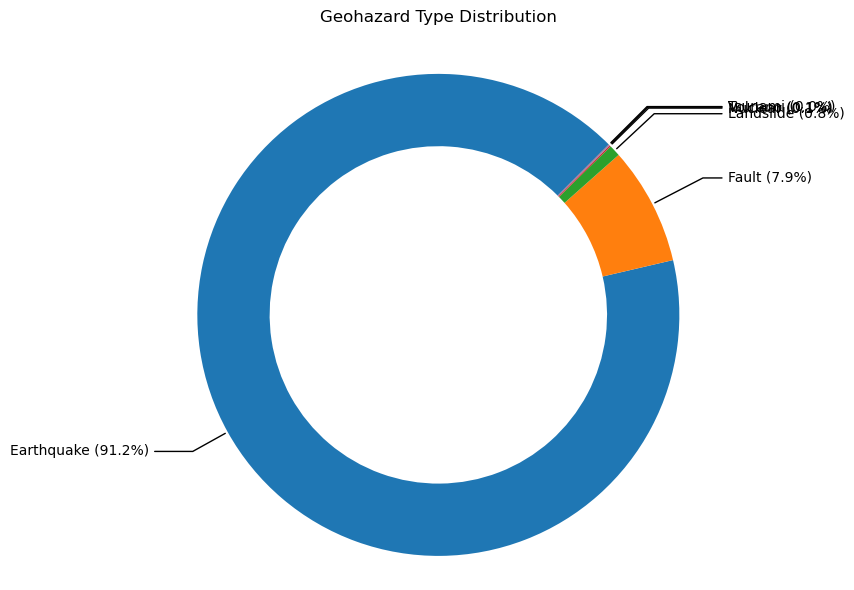

In [ ]:
# Hazard Type Chart
fig, ax = plt.subplots(figsize=(8, 6))

hazard_counts = full_ghz_df['HazardType'].value_counts()
labels = hazard_counts.index.tolist()
sizes = hazard_counts.values

# Plot only wedges and texts
wedges, texts = ax.pie(
    sizes,
    startangle=45,
    wedgeprops=dict(width=0.3),
    pctdistance=0.75
)

# Add label lines and external labels
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)

    ax.annotate(f"{labels[i]} ({sizes[i] / sizes.sum():.1%})",
                xy=(x, y),
                xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

centre_circle = plt.Circle((0, 0), 0.55, fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title("Geohazard Type Distribution", pad=20)
ax.axis('equal')

plt.tight_layout()
# Save the doughnut chart as a PNG image with high resolution
#plt.savefig(r'D:\NDIS_Database\ghz_type.png', dpi=300, transparent=True)
plt.show()

# STAGGERED DECISION STARTS HERE

In [ ]:
# Load Drone and Sensor data
drone_df = pd.read_csv("D:/NDIS_Database/rpas_nonan.csv") # Shortlisted verison of RPAS gdb with no NaN data on distance
sensor_df = pd.read_csv("D:/NDIS_Database/sensor.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_df.info()
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             71 non-null     int64  
 1   country             71 non-null     object 
 2   manufacturer        71 non-null     object 
 3   mfc_model           71 non-null     object 
 4   mtow                70 non-null     float64
 5   length              65 non-null     float64
 6   width               66 non-null     float64
 7   height              60 non-null     float64
 8   max_speed           69 non-null     float64
 9   distance_range      71 non-null     int64  
 10  flight_time         70 non-null     float64
 11  max_payload_weight  70 non-null     float64
 12  max_alt             47 non-null     float64
 13  comm_range          62 non-null     float64
 14  power_source        69 non-null     object 
 15  power               59 non-null     object 
 16  gps_accura

In [ ]:
sensor_df

,sensor_id,parameters,sensor_name,s_encoded,sensor_weight
0,1,velocity,Seismic,1,1000
1,2,susceptibility,Magnetometers,2,1500
2,3,conductivity,EM_Sensor,3,3700
3,4,density,Gravimeter,4,50000
4,5,conductivity,GPR,5,3500
5,6,distance,Lidar,6,900
6,7,spectral,Camera,7,100
7,8,spectral,Hyperspectral,8,1900
8,9,spectral,Multispectral,9,350
9,10,temperature,Thermal_Camera,10,830


# STEP 1: Build Hazard-Stage-Survey Dictionary

In [ ]:
# HazardStage decision mapping
hazard_stage_survey_map = {
    ("Volcano", "pre_event"): ["Magnetometers", "Seismic"],
    ("Volcano", "during"): ["Thermal_Camera", "Camera", "Multispectral"],
    ("Volcano", "post_event"): ["Lidar", "Camera"],
    ("Volcano", "clean_up"): ["Lidar", "Camera"],

    ("Earthquake", "pre_event"): ["Seismic"],
    ("Earthquake", "during"): ["Seismic", "Camera"],
    ("Earthquake", "post_event"): ["Lidar", "Camera"],

    ("Fault", "pre_event"): ["Seismic", "Magnetometers"],
    ("Fault", "post_event"): ["Seismic", "Camera"],

    ("Landslide", "pre_event"): ["Lidar", "GPR"],
    ("Landslide", "during"): ["Camera", "Thermal_Camera"],
    ("Landslide", "post_event"): ["Lidar", "Seismic"],
    ("Landslide", "clean_up"): ["Camera"],

    ("Tsunami", "during"): ["Camera", "Thermal_Camera"],
    ("Tsunami", "post_event"): ["Camera", "Lidar"],
    ("Tsunami", "clean_up"): ["Camera"],

    ("Nuclear", "pre_event"): ["Thermal_Camera", "Camera"],
    ("Nuclear", "during"): ["Thermal_Camera", "Camera"],
    ("Nuclear", "post_event"): ["Camera", "Lidar"],
}

In [ ]:
# Test dict to geohazard dataset
full_ghz_df = ghz_nuc.copy()
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
dtypes: float64(10), int64(1), object(2)
memory usage: 180.1+ MB


In [ ]:
# Step 1: Create haz_stage_key
full_ghz_df["haz_stage_key"] = list(zip(full_ghz_df["HazardType"], full_ghz_df["HazardStage"]))

# Step 2: Map hazard_stage_survey_map
full_ghz_df["SurveyOptions"] = full_ghz_df["haz_stage_key"].map(hazard_stage_survey_map)

# Step 3: Use .where() to replace NaN with empty list []
full_ghz_df["SurveyOptions"] = full_ghz_df["SurveyOptions"].where(full_ghz_df["SurveyOptions"].notna(), [[]])

# STEP 2: Build SurveyType → SensorName Mapping

In [ ]:
survey_sensor_map = {
    "Seismic": "Seismic",
    "Magnetics": "Magnetometers",
    "Thermal_Camera": "Thermal_Camera",
    "Camera": "Camera",
    "Multispectral": "Multispectral",
    "Hyperspectral": "Hyperspectral",
    "Lidar": "Lidar",
    "GPR": "GPR",
    "Electromagnetic" : "EM_Sensor",
    "Gravity" : "Gravimeter"
}

# Step 3: Attach Matched Sensors

In [ ]:
start_time = timeit.default_timer()
# Step 1: Explode SurveyOptions
exploded = full_ghz_df.explode("SurveyOptions")

# Step 2: Map surveys to sensors
exploded["MatchedSensor"] = exploded["SurveyOptions"].map(survey_sensor_map)

# Step 3: Group back without fillna that breaks (handle missing manually)
matched_sensor_series = exploded.groupby(level=0)["MatchedSensor"].apply(lambda x: list(x.dropna()))

# Step 4: Reindex and replace NaN groups with empty lists manually
matched_sensor_series = matched_sensor_series.reindex(full_ghz_df.index)
matched_sensor_series = matched_sensor_series.apply(lambda x: x if isinstance(x, list) else [])

# Step 5: Assign back
full_ghz_df["MatchedSensors"] = matched_sensor_series

elapsed = timeit.default_timer() - start_time
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

✅ All processing completed! Elapsed time: 5.456327900000421 minutes


# STEP 4: Sensor --> Drone Matching

## Sensor Match

In [ ]:
# Step 1: Create lookup for sensor_name -> sensor_weight
sensor_weight_lookup = sensor_df.set_index("sensor_name")["sensor_weight"].to_dict()

# Step 2: Precompute for all sensors the eligible drones
eligible_drones = {}

for sensor_name, weight in sensor_weight_lookup.items():
    eligible_drones[sensor_name] = list(
        drone_df.loc[
            (drone_df["max_payload_weight"] >= weight) &
            (drone_df["max_payload_weight"].notna())
        ]["mfc_model"]
    )

In [ ]:
# Step 3: Assign eligible drones for each MatchedSensor per hazard
def find_eligible_drones(sensor_list):
    drone_set = set()
    for sensor in sensor_list:
        drone_set.update(eligible_drones.get(sensor, []))
    return list(drone_set)

full_ghz_df["EligibleDrones"] = full_ghz_df["MatchedSensors"].apply(find_eligible_drones)

In [ ]:
full_ghz_df.MatchedSensors

0          [Thermal_Camera, Camera, Multispectral]
1          [Thermal_Camera, Camera, Multispectral]
2                                        [Seismic]
3          [Thermal_Camera, Camera, Multispectral]
4                                        [Seismic]
                            ...                   
1816235                   [Thermal_Camera, Camera]
1816236                   [Thermal_Camera, Camera]
1816237                   [Thermal_Camera, Camera]
1816238                   [Thermal_Camera, Camera]
1816239                   [Thermal_Camera, Camera]
Name: MatchedSensors, Length: 1816240, dtype: object

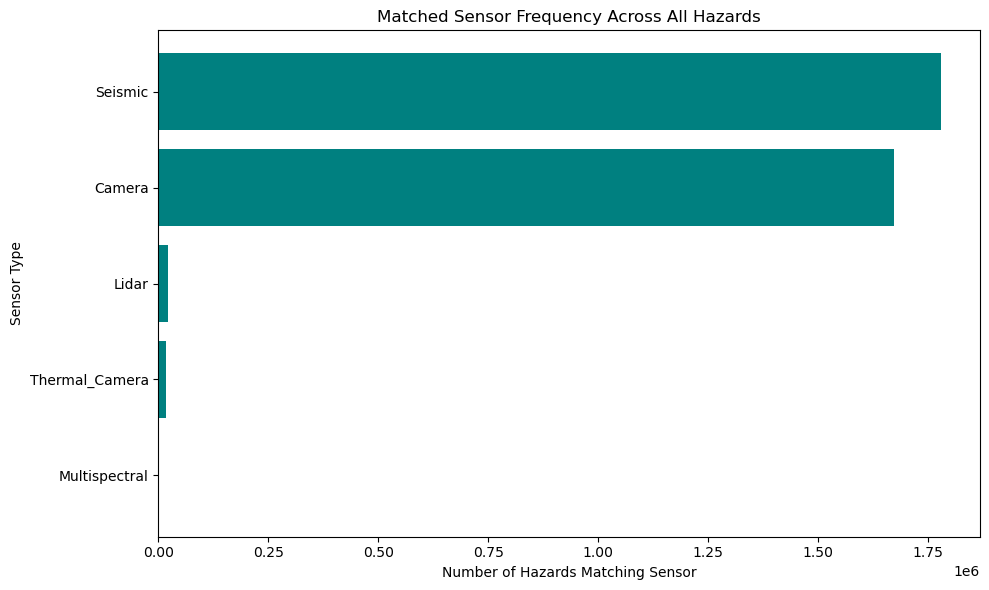

In [ ]:
# Step 1: Flatten all sensor lists into a single long list
all_sensors_flat = [sensor for sensors in full_ghz_df["MatchedSensors"] if isinstance(sensors, list) for sensor in sensors]

# Step 2: Count frequency of each sensor
sensor_counts = Counter(all_sensors_flat)

# Step 3: Convert to DataFrame for plotting
sensor_freq_df = pd.DataFrame(sensor_counts.items(), columns=["Sensor", "Count"]).sort_values(by="Count", ascending=False)

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(sensor_freq_df["Sensor"], sensor_freq_df["Count"], color='teal')
plt.xlabel("Number of Hazards Matching Sensor")
plt.ylabel("Sensor Type")
plt.title("Matched Sensor Frequency Across All Hazards")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# From 'MatchedSensors', grab the sensor_weight
sensor_weight_lookup = sensor_df.set_index("sensor_name")["sensor_weight"].to_dict()

full_ghz_df["sensor_weight"] = full_ghz_df["MatchedSensors"].apply(
    lambda sensors: sensor_weight_lookup.get(sensors[0], 1500) if sensors else 1500
)

In [ ]:
# Step 1: Choose the first suggested sensor from MatchedSensors list
full_ghz_df["PrimarySensor"] = full_ghz_df["MatchedSensors"].apply(
    lambda sensors: sensors[0] if isinstance(sensors, list) and sensors else None
)

# Step 2: Lookup the weight of the PrimarySensor
sensor_weight_lookup = sensor_df.set_index("sensor_name")["sensor_weight"].to_dict()

full_ghz_df["PrimarySensorWeight"] = full_ghz_df["PrimarySensor"].map(sensor_weight_lookup)

## Drone Match

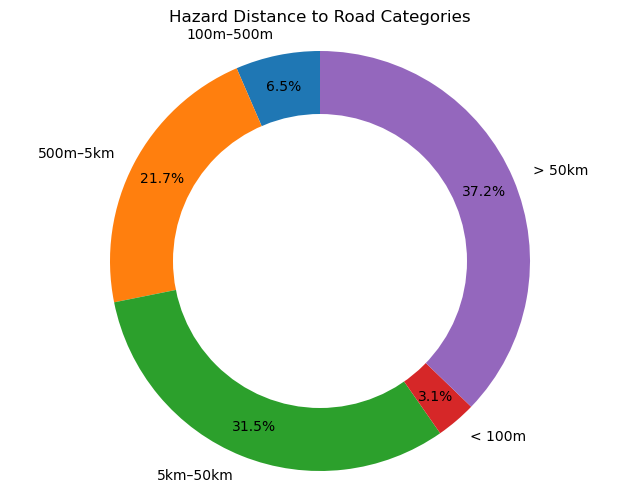

In [ ]:
# Categorize distance into buckets
def categorize_distance(dist):
    if dist <= 100:
        return "< 100m"
    elif dist <= 500:
        return "100m–500m"
    elif dist <= 5000:
        return "500m–5km"
    elif dist <= 50000:
        return "5km–50km"
    else:
        return "> 50km"

# Apply categorization
full_ghz_df["distance_category"] = full_ghz_df["distance"].apply(categorize_distance)

# Count each category
distance_counts = full_ghz_df["distance_category"].value_counts().sort_index()

# Plot donut chart
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    distance_counts,
    labels=distance_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4)
)

# Draw circle for donut hole
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Hazard Distance to Road Categories")

# Save the doughnut chart as a PNG image with high resolution
plt.savefig(r'D:\NDIS_Database\distance_distribution.png', dpi=300, transparent=True)
plt.show()

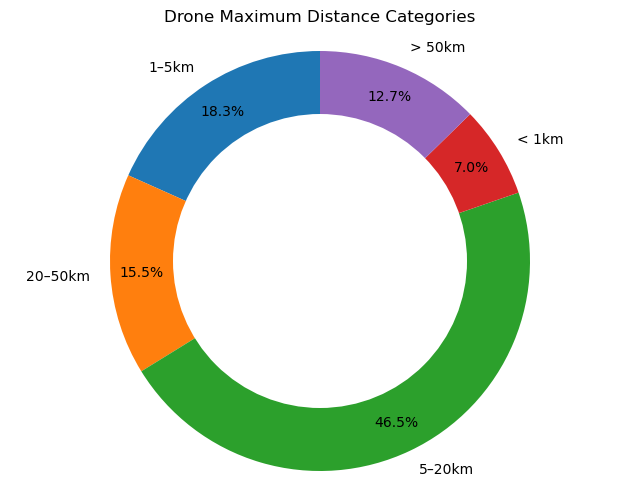

In [ ]:
# Categorize drones by max distance
def categorize_drone_range(dist):
    if dist <= 1000:
        return "< 1km"
    elif dist <= 5000:
        return "1–5km"
    elif dist <= 20000:
        return "5–20km"
    elif dist <= 50000:
        return "20–50km"
    else:
        return "> 50km"

drone_df["distance_category"] = drone_df["distance_range"].apply(categorize_drone_range)

# Count per category
drone_distance_counts = drone_df["distance_category"].value_counts().sort_index()

# Plot donut
fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(
    drone_distance_counts,
    labels=drone_distance_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4)
)

# Draw donut hole
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("Drone Maximum Distance Categories")
# Save the doughnut chart as a PNG image with high resolution

plt.savefig(r'D:\NDIS_Database\dronedistance_distribution.png', dpi=300, transparent=True)

plt.show()

In [ ]:
drone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             71 non-null     int64  
 1   country             71 non-null     object 
 2   manufacturer        71 non-null     object 
 3   drone_model         71 non-null     object 
 4   mtow                70 non-null     float64
 5   length              65 non-null     float64
 6   width               66 non-null     float64
 7   height              60 non-null     float64
 8   max_speed           69 non-null     float64
 9   distance_range_m    71 non-null     int64  
 10  flight_time         70 non-null     float64
 11  payload_capacity_g  70 non-null     float64
 12  max_alt             47 non-null     float64
 13  comm_range          62 non-null     float64
 14  power_source        69 non-null     object 
 15  power               59 non-null     object 
 16  gps_accura

In [ ]:
# Step 1: Select drones with distance range between 5km–20km
cat1 = drone_df[
    (drone_df["distance_range_m"] <= 5000)
]

# Step 2: Pull out the model name and max payload weight
cat1_summary = cat1[["drone_model", "distance_range_m", "payload_capacity_g"]].sort_values(by="payload_capacity_g", ascending=True)

# Step 3: Show data
cat1_summary

,drone_model,distance_range_m,payload_capacity_g
0,Autel Robotics EVO II Dual 640T RTK Rugged Bundle,21,0.0
1,Zhuoyi Droneeye TS-A12,300,0.0
2,ACSL Fi4,700,0.0
13,Parrot ANAFIAi,4000,0.0
11,DJI Mavic Mini,4000,0.0
5,DJI Spark,2000,0.0
10,Skydio 2A,3000,230.0
9,Skydio 2+,3000,230.0
8,Skydio 2,3000,230.0
16,AEE Aviation Technology MACH4-5G,5000,400.0


In [ ]:
# Step 1: Select drones with distance range between 5km–20km
mid_range_drones = drone_df[
    (drone_df["distance_range"] >= 5000) &
    (drone_df["distance_range"] <= 20000)
]

# Step 2: Pull out the model name and max payload weight
mid_range_summary = mid_range_drones[["mfc_model", "distance_range", "max_payload_weight"]].sort_values(by="max_payload_weight", ascending=True)

# Step 3: Show the top ones
mid_range_summary

,mfc_model,distance_range,max_payload_weight
31,DJI FPV,10000,0.0
48,DJI Mavic2Zoom,18000,0.0
47,DJI Mavic2Pro,18000,0.0
18,DJI Phantom4ProV2.0,7000,0.0
19,DJI Phantom4RTK,7000,0.0
20,DJI Inspire2,7000,0.0
26,DJI Mavic2EnterpriseDual,8000,0.0
30,DJI Mavic Air,10000,0.0
25,DJI Mavic2Enterprise,8000,0.0
35,ACSL SOTEN,12000,10.0


In [ ]:
# Step 1: Select drones with distance range between 5km–20km
cat3 = drone_df[
    (drone_df["distance_range"] >= 20000) &
    (drone_df["distance_range"] <= 50000) &
    (drone_df["max_payload_weight"] >= 800)
]

# Step 2: Pull out the model name and max payload weight
cat3_summary = cat3[["mfc_model", "distance_range", "max_payload_weight"]].sort_values(by="max_payload_weight", ascending=True)

# Step 3: Show the top ones
cat3_summary

,mfc_model,distance_range,max_payload_weight
61,WingtraOne Gen II,50000,800.0
59,AeroSense Aerobo Wing (AS-VT01),50000,1000.0
55,Garuda Robotics Cerana ONE Pro,30240,1200.0
60,Doosan Mobility DS30W,50000,3000.0
56,DJI S900,35000,4700.0
50,ACSL AirTruck,20000,5000.0
58,Garuda Robotics Cerana X8,45000,8000.0
52,Dragandfly Innovations Inc Starling X.2,27000,10000.0
57,Freespace Operation Callisto 50 Multirotor,40000,25000.0
53,Dragandfly Innovations Inc Heavy Lift Drone,30000,30000.0


In [ ]:
sensor_df

,sensor_id,parameters,sensor_name,s_encoded,sensor_weight
0,1,velocity,Seismic,1,1000
1,2,susceptibility,Magnetometers,2,1500
2,3,conductivity,EM_Sensor,3,3700
3,4,density,Gravimeter,4,50000
4,5,conductivity,GPR,5,3500
5,6,distance,Lidar,6,900
6,7,spectral,Camera,7,100
7,8,spectral,Hyperspectral,8,1900
8,9,spectral,Multispectral,9,350
9,10,temperature,Thermal_Camera,10,830


In [ ]:
def get_top_3_drones_by_payload(drones, sensor_weight):
    candidates = []
    for drone in drones:
        specs = drone_specs_lookup.get(drone)
        if specs:
            max_payload = specs.get("max_payload_weight", 0)
            if max_payload >= sensor_weight:
                candidates.append((drone, max_payload))
    # Sort by how closely they match the sensor weight (lightest excess first)
    candidates_sorted = sorted(candidates, key=lambda x: x[1])
    return [drone for drone, _ in candidates_sorted[:3]]  # Top 3

### Filtering based on Categorized Matching

In [ ]:
def flexible_filter(drones, hazard_distance):
    result = []
    for drone in drones:
        dist = drone_range_lookup.get(drone, 0)
        # Allow fallback based on tiers
        if hazard_distance <= 100:  # almost anything
            result.append(drone)
        elif hazard_distance <= 500:
            if dist >= hazard_distance * 0.5:
                result.append(drone)
        elif hazard_distance <= 50000:
            if dist >= hazard_distance * 0.8:
                result.append(drone)
        else:  # distance > 50 km
            # If no drone can reach, allow highest range anyway
            if dist >= 50000 or dist == max(drone_range_lookup.values()):
                result.append(drone)
    return result

In [ ]:
start = timeit.default_timer()

full_ghz_df["FilteredDrones"] = full_ghz_df.apply(
    lambda row: flexible_filter(row["EligibleDrones"], row["distance"]),
    axis=1
)

elapsed = timeit.default_timer() - start
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

✅ All processing completed! Elapsed time: 3.4243129200001325 minutes


In [ ]:
full_ghz_df["FilteredDrones"]

0          [Drone America Savant, JOUAV CW-15, Skydio 2A,...
1          [Drone America Savant, JOUAV CW-15, Skydio 2A,...
2          [Drone America Savant, JOUAV CW-15, Drone Volt...
3          [Drone America Savant, JOUAV CW-15, Skydio 2A,...
4          [Drone America Savant, JOUAV CW-15, Drone Volt...
                                 ...                        
1816235    [Drone America Savant, JOUAV CW-15, Skydio 2A,...
1816236    [Drone America Savant, JOUAV CW-15, Skydio 2A,...
1816237    [Drone America Savant, JOUAV CW-15, Skydio 2A,...
1816238    [Drone America Savant, JOUAV CW-15, Skydio 2A,...
1816239    [Drone America Savant, JOUAV CW-15, Skydio 2A,...
Name: FilteredDrones, Length: 1816240, dtype: object

In [ ]:
start = timeit.default_timer()

# Create new column 'Top3Drones'
full_ghz_df["Top3Drones"] = full_ghz_df.apply(
    lambda row: get_top_3_drones_by_payload(row["FilteredDrones"], row["PrimarySensorWeight"]),
    axis=1
)

elapsed = timeit.default_timer() - start
print(f"✅ Top 3 drones assigned! Time: {elapsed / 60:.2f} minutes")

✅ Top 3 drones assigned! Time: 1.41 minutes


In [ ]:
# Optional: Lookup drone specs for top 3
def fetch_drone_specs(drone_list):
    return [drone_specs_lookup.get(d, {}) for d in drone_list]

full_ghz_df["Top3Specs"] = full_ghz_df["Top3Drones"].apply(fetch_drone_specs)

In [ ]:
full_ghz_df["Top3Drones"]

0          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
2          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
3          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
4          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
                                 ...                        
1816235    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816236    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816237    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816238    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816239    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
Name: Top3Drones, Length: 1816240, dtype: object

In [ ]:
# Flatten all Top3Drones into one big list
all_top_drones = [drone for drone_list in full_ghz_df["Top3Drones"] if isinstance(drone_list, list) for drone in drone_list]

# Count frequency
drone_freq = Counter(all_top_drones)

# Convert to DataFrame
drone_freq_df = pd.DataFrame(drone_freq.items(), columns=["Drone", "Count"]).sort_values(by="Count", ascending=False)

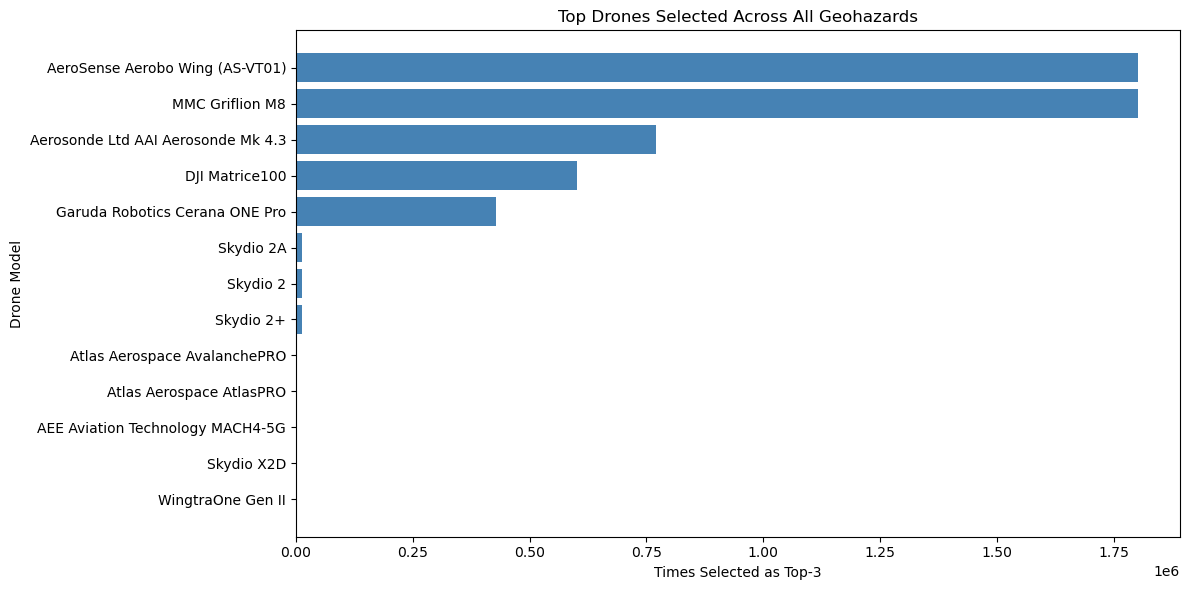

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.barh(drone_freq_df["Drone"], drone_freq_df["Count"], color="steelblue")
plt.xlabel("Times Selected as Top-3")
plt.ylabel("Drone Model")
plt.title("Top Drones Selected Across All Geohazards")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# More flexible categorized rule for drone seleczionne
start = timeit.default_timer()


# Define function to assign category
def categorize_distance(dist):
    if dist <= 100:
        return "< 100m"
    elif dist <= 500:
        return "100m–500m"
    elif dist <= 5000:
        return "500m–5km"
    elif dist <= 50000:
        return "5km–50km"
    else:
        return "> 50km"

# Create distance_category
full_ghz_df["distance_category"] = full_ghz_df["distance"].apply(categorize_distance)

# Flexible filter function
def filter_drones_flexible(drones, hazard_distance, category):
    if category == "< 100m":
        threshold = 1.0  # 100%
    elif category == "100m–500m":
        threshold = 0.8  # 80%
    elif category == "500m–5km":
        threshold = 0.6  # 60%
    elif category == "5km–50km":
        threshold = 0.4  # 40%
    else:  # "> 50km"
        threshold = 0.0  # any drone distance OK

    good_drones = []
    for drone in drones:
        drone_range = drone_range_lookup.get(drone, 0)
        if threshold == 0.0 or drone_range >= hazard_distance * threshold:
            good_drones.append(drone)
    return good_drones

# Apply flexible filter
full_ghz_df["FilteredDrones"] = full_ghz_df.apply(
    lambda row: filter_drones_flexible(row["EligibleDrones"], row["distance"], row["distance_category"]),
    axis=1
)

elapsed = timeit.default_timer() - start
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

✅ All processing completed! Elapsed time: 1.3796044233332698 minutes


In [ ]:
# Drone specs lookup
drone_specs_lookup = drone_df.set_index("mfc_model")[[
    "max_speed", "flight_time", "max_payload_weight", "distance_range"
]].to_dict(orient="index")

In [ ]:
# Select best drone based on sensor payload compatibility (smallest excess capacity)
def pick_best_drone_by_payload(drones, sensor_weight):
    best_drone = None
    best_excess = float('inf')  # Smallest extra payload capacity wins
    for drone in drones:
        specs = drone_specs_lookup.get(drone, None)
        if specs:
            payload_capacity = specs["max_payload_weight"]
            excess = payload_capacity - sensor_weight
            if excess >= 0 and excess < best_excess:
                best_drone = drone
                best_excess = excess
    if best_drone:
        return best_drone, drone_specs_lookup[best_drone]
    else:
        return None, {}

In [ ]:
# Define fallback mapping
sensor_fallback_map = {
    "Gravimeter": None,         # No fallback
    "EM_Sensor": "Camera",       # Fallback to visual mapping
    "GPR": "Lidar"               # Fallback to Lidar
    # others don't need fallback
}

# Updated best drone picking with fallback logic
def pick_best_drone_with_fallback(drones, primary_sensor, sensor_weight):
    # First attempt: match primary sensor
    best_drone = None
    best_excess = float('inf')
    for drone in drones:
        specs = drone_specs_lookup.get(drone, None)
        if specs:
            payload_capacity = specs["max_payload_weight"]
            excess = payload_capacity - sensor_weight
            if excess >= 0 and excess < best_excess:
                best_drone = drone
                best_excess = excess

    # If primary fails, fallback to lighter sensor
    if best_drone is None:
        fallback_sensor = sensor_fallback_map.get(primary_sensor, None)
        if fallback_sensor:
            fallback_weight = sensor_df.loc[sensor_df["sensor_name"] == fallback_sensor, "sensor_weight"].values[0]
            for drone in drones:
                specs = drone_specs_lookup.get(drone, None)
                if specs:
                    payload_capacity = specs["max_payload_weight"]
                    excess = payload_capacity - fallback_weight
                    if excess >= 0 and excess < best_excess:
                        best_drone = drone
                        best_excess = excess
            return fallback_sensor, best_drone, drone_specs_lookup[best_drone] if best_drone else None
        else:
            return None, None, None  # No fallback and no drone
    else:
        return primary_sensor, best_drone, drone_specs_lookup[best_drone]


In [ ]:
start = timeit.default_timer()

# Step 1: Prioritize payload match first
def pick_best_drone_by_payload_only(drones, required_payload):
    best_drone = None
    min_excess_payload = float('inf')
    for drone in drones:
        specs = drone_specs_lookup.get(drone, None)
        if specs:
            max_payload = specs["max_payload_weight"]
            excess = max_payload - required_payload
            if excess >= 0 and excess < min_excess_payload:
                best_drone = drone
                min_excess_payload = excess
    return best_drone, drone_specs_lookup.get(best_drone, None) if best_drone else (None, None)

# Step 2: Apply it
full_ghz_df[["BestDrone", "BestDroneSpecs"]] = full_ghz_df.apply(
    lambda row: pd.Series(
        pick_best_drone_by_payload_only(row["FilteredDrones"], row["PrimarySensorWeight"])
    ),
    axis=1
)

elapsed = timeit.default_timer() - start
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

✅ All processing completed! Elapsed time: 10.690105721666866 minutes


In [ ]:
start = timeit.default_timer()

# Split into two columns: BestDrone and BestDroneSpecs
full_ghz_df[["SelectedSensor", "BestDrone", "BestDroneSpecs"]] = full_ghz_df.apply(
    lambda row: pd.Series(
        pick_best_drone_with_fallback(row["FilteredDrones"], row["PrimarySensor"], row["PrimarySensorWeight"])
    ),
    axis=1
)

elapsed = timeit.default_timer() - start
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

✅ All processing completed! Elapsed time: 12.287485069999821 minutes


In [ ]:
full_ghz_df['BestDrone'].unique()

array(['DJI Matrice100', 'AeroSense Aerobo Wing (AS-VT01)', 'Skydio 2A',
       'Atlas Aerospace AvalanchePRO', 'WingtraOne Gen II'], dtype=object)

In [ ]:
full_ghz_df.to_csv(r"D:\NDIS_Database\ghz_nuke.csv", index=False)

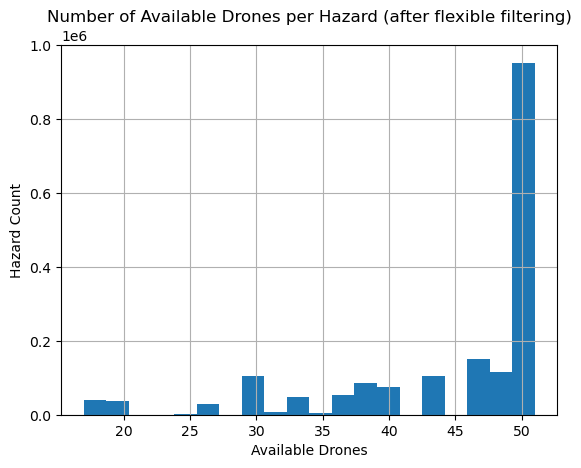

In [ ]:
full_ghz_df["FilteredDrones"].apply(len).hist(bins=20)
plt.title("Number of Available Drones per Hazard (after flexible filtering)")
plt.xlabel("Available Drones")
plt.ylabel("Hazard Count")
plt.show()

# Step 5: Travel Time + CPM Total Time Calculation

In [ ]:
# Step 1: Pull speed from BestDroneSpecs
def extract_speed(specs):
    if isinstance(specs, dict):
        return specs.get("max_speed", None)
    return None

full_ghz_df["DroneSpeed_mps"] = full_ghz_df["BestDroneSpecs"].apply(extract_speed)

# Step 2: Calculate travel_time (minutes)
# Note: Distance is assumed to be in meters, speed in meters/second
full_ghz_df["travel_time"] = (full_ghz_df["distance"] / full_ghz_df["DroneSpeed_mps"]) / 60

# Step 3: Calculate cpm_total_time
full_ghz_df["cpm_total_time"] = (2 * full_ghz_df["travel_time"]) + full_ghz_df["monitor_time"]

In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  MatchedSensors         object 
 16  EligibleDrones         object 
 17  FilteredDrones         object 
 18  BestDrone              object 
 19  BestDroneSpecs         object 
 20  DroneSpeed_mps         float64
dtypes: float64(11), int64(1), object(9)
memory usage: 291.

In [ ]:
full_ghz_df.distance.unique()

array([  34.46209164, 1068.0630728 , 1798.38819575, ..., 2580.10337017,
        253.45529458,   32.2593214 ])

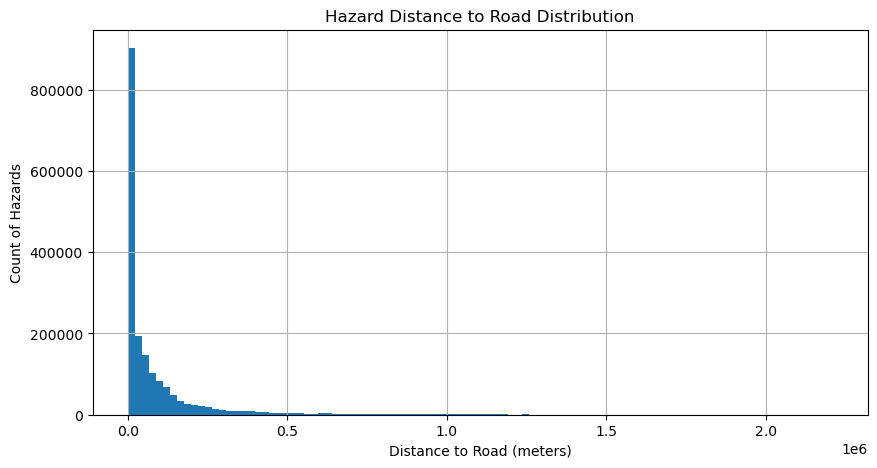

In [ ]:
# Distance Histogram
full_ghz_df["distance"].hist(bins=100, figsize=(10,5))
plt.xlabel("Distance to Road (meters)")
plt.ylabel("Count of Hazards")
plt.title("Hazard Distance to Road Distribution")
plt.show()

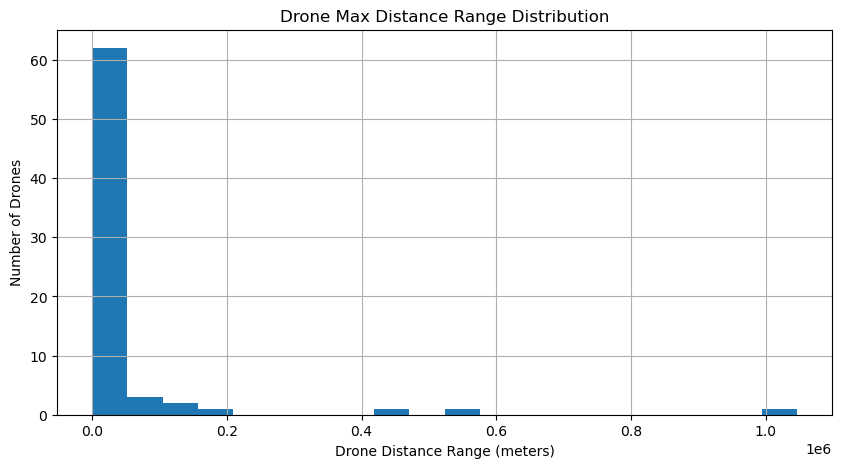

In [ ]:
# Drone Range Distribution
drone_df["distance_range"].hist(bins=20, figsize=(10,5))
plt.xlabel("Drone Distance Range (meters)")
plt.ylabel("Number of Drones")
plt.title("Drone Max Distance Range Distribution")
plt.show()

In [ ]:
# More flexible categorized rule for drone seleczionne
start = timeit.default_timer()


# Define function to assign category
def categorize_distance(dist):
    if dist <= 100:
        return "< 100m"
    elif dist <= 500:
        return "100m–500m"
    elif dist <= 5000:
        return "500m–5km"
    elif dist <= 50000:
        return "5km–50km"
    else:
        return "> 50km"

# Create distance_category
full_ghz_df["distance_category"] = full_ghz_df["distance"].apply(categorize_distance)

# Flexible filter function
def filter_drones_flexible(drones, hazard_distance, category):
    if category == "< 100m":
        threshold = 1.0  # 100%
    elif category == "100m–500m":
        threshold = 0.8  # 80%
    elif category == "500m–5km":
        threshold = 0.6  # 60%
    elif category == "5km–50km":
        threshold = 0.4  # 40%
    else:  # "> 50km"
        threshold = 0.0  # any drone distance OK

    good_drones = []
    for drone in drones:
        drone_range = drone_range_lookup.get(drone, 0)
        if threshold == 0.0 or drone_range >= hazard_distance * threshold:
            good_drones.append(drone)
    return good_drones

# Apply flexible filter
full_ghz_df["FilteredDrones"] = full_ghz_df.apply(
    lambda row: filter_drones_flexible(row["EligibleDrones"], row["distance"], row["distance_category"]),
    axis=1
)

elapsed = timeit.default_timer() - start
print("\u2705 All processing completed! Elapsed time: %s minutes"%str(elapsed/60))

✅ All processing completed! Elapsed time: 1.2593793216665896 minutes


In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  MatchedSensors         object 
 16  EligibleDrones         object 
 17  FilteredDrones         object 
 18  BestDrone              object 
 19  BestDroneSpecs         object 
 20  DroneSpeed_mps         float64
 21  distance_category      object 
dtypes: float64(11), in

In [ ]:
# Function based on balanced-fit
def get_top_3_drones_by_payload_diverse(drones, sensor_weight):
    eligible = []
    for drone in drones:
        specs = drone_specs_lookup.get(drone)
        if specs and specs.get("max_payload_weight", 0) >= sensor_weight:
            eligible.append((drone, specs["max_payload_weight"]))

    eligible = sorted(eligible, key=lambda x: abs(x[1] - sensor_weight))
    return [d[0] for d in eligible[:3]]

In [ ]:
# Apply the diverse top-3 drone selector
start = timeit.default_timer()

full_ghz_df["Top3Drones"] = full_ghz_df.apply(
    lambda row: get_top_3_drones_by_payload_diverse(row["FilteredDrones"], row["PrimarySensorWeight"]),
    axis=1
)

# Optional: Get full specs for Top3
full_ghz_df["Top3Specs"] = full_ghz_df["Top3Drones"].apply(fetch_drone_specs)

elapsed = timeit.default_timer() - start
print(f"✅ Diverse Top-3 drones assigned! Time: {elapsed / 60:.2f} minutes")

✅ Diverse Top-3 drones assigned! Time: 1.56 minutes


In [ ]:
full_ghz_df["Top3Drones"]

0          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
2          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
3          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
4          [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
                                 ...                        
1816235    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816236    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816237    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816238    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
1816239    [DJI Matrice100, AeroSense Aerobo Wing (AS-VT0...
Name: Top3Drones, Length: 1816240, dtype: object

In [ ]:
# Flatten all Top3Drones into one big list
all_top_drones = [drone for drone_list in full_ghz_df["Top3Drones"] if isinstance(drone_list, list) for drone in drone_list]

# Count frequency
drone_freq = Counter(all_top_drones)

# Convert to DataFrame
drone_freq_df = pd.DataFrame(drone_freq.items(), columns=["Drone", "Count"]).sort_values(by="Count", ascending=False)

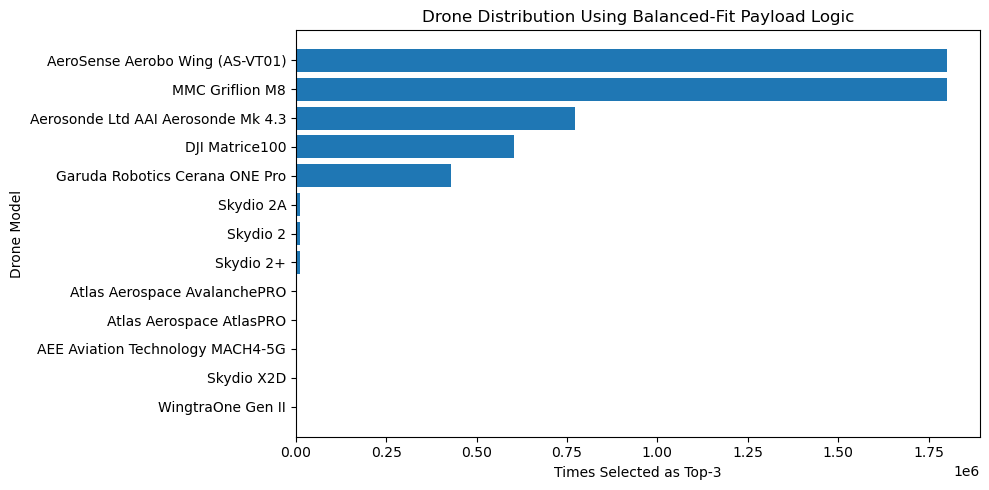

In [ ]:
# See Top 3 drone list
plt.figure(figsize=(10, 5))
plt.barh(drone_freq_df["Drone"], drone_freq_df["Count"])
plt.xlabel("Times Selected as Top-3")
plt.ylabel("Drone Model")
plt.title("Drone Distribution Using Balanced-Fit Payload Logic")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
print("Unique Top-3 Drones:", full_ghz_df["Top3Drones"].explode().nunique())
print(full_ghz_df["Top3Drones"].explode().value_counts().head(10))

Unique Top-3 Drones: 13
Top3Drones
AeroSense Aerobo Wing (AS-VT01)       1802105
MMC Griflion M8                       1802105
Aerosonde Ltd AAI Aerosonde Mk 4.3     771370
DJI Matrice100                         602132
Garuda Robotics Cerana ONE Pro         428467
Skydio 2A                               12612
Skydio 2                                12612
Skydio 2+                               12612
Atlas Aerospace AvalanchePRO             1523
Atlas Aerospace AtlasPRO                 1523
Name: count, dtype: int64


In [ ]:
sample_row = full_ghz_df.iloc[0]  # or another random row
print("Filtered Drones:", sample_row["FilteredDrones"])
print("Sensor Weight:", sample_row["PrimarySensorWeight"])
print("Top 3 Drones:", sample_row["Top3Drones"])

Filtered Drones: ['Drone America Savant', 'JOUAV CW-15', 'Skydio 2A', 'Skydio X2D', 'AEE Aviation Technology MACH4-5G', 'Drone Volt Hercules 10', 'Freespace Operation Callisto 50 Multirotor', 'AEE Aviation Technology F6000', 'Acecore Noa 6', 'Skydio X2', 'Acecore Noa 6 25', 'JTT Spider C85', 'WingtraOne Gen II', 'Aerosonde Ltd AAI Aerosonde Mk 4.3', 'Acecore Noa H6 Hybrid', 'Skydio X2E', 'HG Robotics VETAL', 'DJI Matrice100', 'Acecore Zoe X4', 'Dragandfly Innovations Inc Heavy Lift Drone', 'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection', 'AeroSense Aerobo Wing (AS-VT01)', 'DJI AgrasT20', 'DJI Matrice200V2', 'DJI S900', 'Aerialtronics Altura Zenith ATX8', 'DJI FlyCart 30', 'DJI Matrice200SeriesV2', 'Acecore Neo X8', 'IDEAFLY Thor-850', 'ACSL AirTruck', 'Doosan Mobility Dj25', 'Atlas Aerospace AvalanchePRO', 'Garuda Robotics Cerana X8', 'MMC Griflion M8', 'Dragandfly Innovations Inc Starling X.2', 'Acecore Zetona 8', 'Skydio 2', 'EAMS E484MP', 'AEE Aviation Technology G10', 'Dro

In [ ]:
def get_top_3_drones_payload_soft(drones, sensor_weight):
    eligible = []
    for drone in drones:
        specs = drone_specs_lookup.get(drone)
        if specs:
            max_payload = specs.get("max_payload_weight", 0)
            # Allow drones with up to 3.5x sensor weight
            if sensor_weight <= max_payload <= sensor_weight * 3.5:
                eligible.append((drone, max_payload))

    # Sort by closeness to the sensor weight (optional)
    eligible.sort(key=lambda x: abs(x[1] - sensor_weight))

    # If not enough drones, relax constraint even further
    if len(eligible) < 3:
        for drone in drones:
            specs = drone_specs_lookup.get(drone)
            if specs:
                eligible.append((drone, specs.get("max_payload_weight", 0)))
        eligible = sorted(list(set(eligible)), key=lambda x: abs(x[1] - sensor_weight))

    return [d[0] for d in eligible[:3]]


In [ ]:
full_ghz_df["Top3Drones"] = full_ghz_df.apply(
    lambda row: get_top_3_drones_payload_soft(row["FilteredDrones"], row["PrimarySensorWeight"]),
    axis=1
)

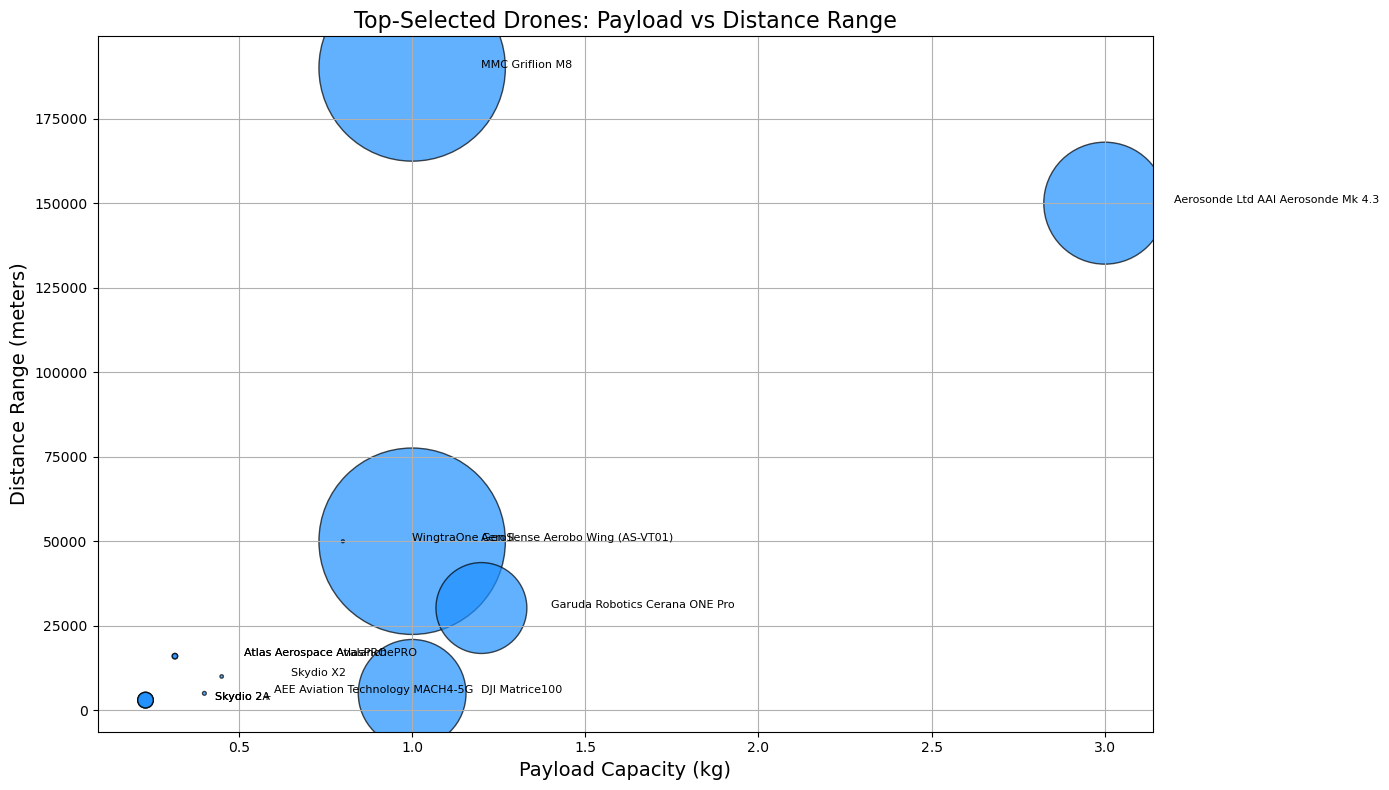

In [ ]:
# Step 1: Flatten Top-3 Drones into a list
all_top_drones = [
    drone for drone_list in full_ghz_df["Top3Drones"]
    if isinstance(drone_list, list)
    for drone in drone_list
]

# Step 2: Count the frequency of each drone
drone_freq = Counter(all_top_drones)

# Step 3: Build a DataFrame for plotting
scatter_data = []
for drone, count in drone_freq.items():
    specs = drone_specs_lookup.get(drone, None)
    if specs:
        scatter_data.append({
            "Drone": drone,
            "Payload_kg": specs.get("max_payload_weight", 0) / 1000,  # convert grams to kg if needed
            "Range_m": specs.get("distance_range", 0),
            "Count": count
        })

scatter_df = pd.DataFrame(scatter_data)

# Step 4: Plot
plt.figure(figsize=(14, 8))
plt.scatter(
    scatter_df["Payload_kg"],
    scatter_df["Range_m"],
    s=scatter_df["Count"] / 100,  # scale bubble size down a bit
    alpha=0.7,
    color='dodgerblue',
    edgecolors='black'
)

for idx, row in scatter_df.iterrows():
    plt.text(row["Payload_kg"]+0.2, row["Range_m"], row["Drone"], fontsize=8)

plt.title("Top-Selected Drones: Payload vs Distance Range", fontsize=16)
plt.xlabel("Payload Capacity (kg)", fontsize=14)
plt.ylabel("Distance Range (meters)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  MatchedSensors         object 
 16  EligibleDrones         object 
 17  FilteredDrones         object 
 18  BestDrone              object 
 19  BestDroneSpecs         object 
 20  DroneSpeed_mps         float64
 21  distance_category      object 
 22  sensor_weight     

In [ ]:
def score_drones_for_row(row, drone_df, w_distance=0.5, w_payload=0.4, w_penalty=0.3):
    hazard_distance = row['distance']  # already in meters
    sensor_weight_kg = row['sensor_weight'] / 1000.0  # convert grams → kg

    best_drones = []
    for _, drone in drone_df.iterrows():
        d_model = drone['drone_model']
        d_payload = drone['payload_capacity_kg']
        d_range = drone['distance_range_m']

        if pd.isna(d_payload) or pd.isna(d_range):
            continue

        # Convert drone payload to kg if needed
        d_payload_kg = d_payload / 1000.0

        # Matching scores
        distance_score = max(0, 1 - abs(hazard_distance - d_range) / hazard_distance)
        payload_score = 1 if d_payload_kg >= sensor_weight_kg else d_payload_kg / sensor_weight_kg

        # Overkill penalty
        payload_over = max(0, d_payload_kg - sensor_weight_kg)
        distance_over = max(0, d_range - hazard_distance)
        overkill_penalty = (payload_over / sensor_weight_kg + distance_over / hazard_distance) / 2

        score = (
            w_distance * distance_score +
            w_payload * payload_score -
            w_penalty * overkill_penalty
        )

        best_drones.append({
            'drone_model': d_model,
            'distance_score': distance_score,
            'payload_score': payload_score,
            'overkill_penalty': overkill_penalty,
            'final_score': score,
            'payload_capacity_kg': d_payload_kg,
            'distance_range_m': d_range
        })

    if not best_drones:
        return pd.Series({'BestDrone': None, 'BestDroneSpecs': None, 'Top3Drones': None, 'Top3Specs': None})

    sorted_drones = sorted(best_drones, key=lambda x: x['final_score'], reverse=True)
    top3 = sorted_drones[:3]
    return pd.Series({
        'BestDrone': top3[0]['drone_model'],
        'BestDroneSpecs': top3[0],
        'Top3Drones': ', '.join([d['drone_model'] for d in top3]),
        'Top3Specs': str(top3)
    })


In [ ]:
scored_cols = full_ghz_df.apply(lambda row: score_drones_for_row(row, drone_df), axis=1)
full_ghz_df[['BestDrone', 'BestDroneSpecs', 'Top3Drones', 'Top3Specs']] = scored_cols

In [ ]:
def cleanup_python_temp_files():
    temp_dir = tempfile.gettempdir()
    patterns = ('joblib', 'tmp', '__MEI', 'pip-', 'matplotlib', 'MEI', 'sklearn')

    for item in os.listdir(temp_dir):
        item_path = os.path.join(temp_dir, item)
        if any(p in item for p in patterns):
            try:
                if os.path.isdir(item_path):
                    shutil.rmtree(item_path, ignore_errors=True)
                elif os.path.isfile(item_path):
                    os.remove(item_path)
            except Exception as e:
                print(f"Skipped {item_path}: {e}")

def chunked_score_and_merge(full_df, drone_df, chunk_size=50000):
    drone_df = drone_df.rename(columns={
        'mfc_model': 'drone_model',
        'max_payload_weight': 'payload_capacity_g',
        'distance_range': 'distance_range_m'
    })

    all_results = []

    for start in range(0, len(full_df), chunk_size):
        print(f"Processing chunk {start} to {start+chunk_size}...")
        chunk = full_df.iloc[start:start + chunk_size].copy()
        chunk['key'] = 1
        drone_df['key'] = 1

        merged = chunk.merge(drone_df, on='key').drop('key', axis=1)

        # Score calculation
        hazard_distance = merged['distance']
        sensor_weight = merged['sensor_weight']
        d_payload = merged['payload_capacity_g']
        d_range = merged['distance_range_m']

        distance_score = (1 - (abs(hazard_distance - d_range) / hazard_distance)).clip(lower=0)
        payload_score = np.where(d_payload >= sensor_weight, 1, d_payload / sensor_weight)
        payload_over = np.maximum(0, d_payload - sensor_weight)
        distance_over = np.maximum(0, d_range - hazard_distance)
        overkill_penalty = (payload_over / sensor_weight + distance_over / hazard_distance) / 2

        w_distance = 0.5
        w_payload = 0.4
        w_penalty = 0.3
        final_score = (w_distance * distance_score) + (w_payload * payload_score) - (w_penalty * overkill_penalty)

        merged['final_score'] = final_score
        merged['drone_info'] = merged[['drone_model', 'distance_range_m', 'payload_capacity_g']].to_dict(orient='records')

        top3 = (
            merged.sort_values(['HazardID', 'final_score'], ascending=[True, False])
            .groupby('HazardID')
            .head(3)
        )

        # Aggregate per HazardID
        def agg(group):
            sorted_g = group.sort_values('final_score', ascending=False)
            return pd.Series({
                'BestDrone': sorted_g.iloc[0]['drone_model'],
                'BestDroneSpecs': sorted_g.iloc[0]['drone_info'],
                'Top3Drones': ', '.join(sorted_g['drone_model'].values),
                'Top3Specs': str(list(sorted_g['drone_info'].values))
            })

        result = top3.groupby('HazardID').apply(agg).reset_index()
        all_results.append(result)

        # Cleanup RAM and temp
        del merged, top3, result
        gc.collect()
        cleanup_python_temp_files()

    return pd.concat(all_results, ignore_index=True)


In [ ]:
start = timeit.default_timer()

# Use it
top3_final = chunked_score_and_merge(full_ghz_df, drone_df, chunk_size=50000)
full_ghz_df = full_ghz_df.merge(top3_final, on='HazardID', how='left')

elapsed = timeit.default_timer() - start
print(f"✅ Diverse Top-3 drones assigned! Time: {elapsed / 60:.2f} minutes")

Processing chunk 0 to 50000...
Skipped C:\Users\Dell\AppData\Local\Temp\ArcGISProTemp8072\148484c4-3079-4e7a-afc0-9c71a799f901.tmp: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Dell\\AppData\\Local\\Temp\\ArcGISProTemp8072\\148484c4-3079-4e7a-afc0-9c71a799f901.tmp'
Skipped C:\Users\Dell\AppData\Local\Temp\ArcGISProTemp8072\41ae82a4-6916-4e5c-91c5-6b237dba790b.tmp: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Dell\\AppData\\Local\\Temp\\ArcGISProTemp8072\\41ae82a4-6916-4e5c-91c5-6b237dba790b.tmp'
Skipped C:\Users\Dell\AppData\Local\Temp\ArcGISProTemp8072\5f699898-6baa-48be-b0a9-a10cf483a3b5.tmp: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Dell\\AppData\\Local\\Temp\\ArcGISProTemp8072\\5f699898-6baa-48be-b0a9-a10cf483a3b5.tmp'
Skipped C:\Users\Dell\AppData\Local\Temp\ArcGISProTemp8072\c5f80a96-2767-4a76-83f

In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816660 entries, 0 to 1816659
Data columns (total 33 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  MatchedSensors         object 
 16  EligibleDrones         object 
 17  FilteredDrones         object 
 18  BestDrone_x            object 
 19  BestDroneSpecs_x       object 
 20  DroneSpeed_mps         float64
 21  distance_category      object 
 22  sensor_weight     

In [ ]:

gc.collect()

9220

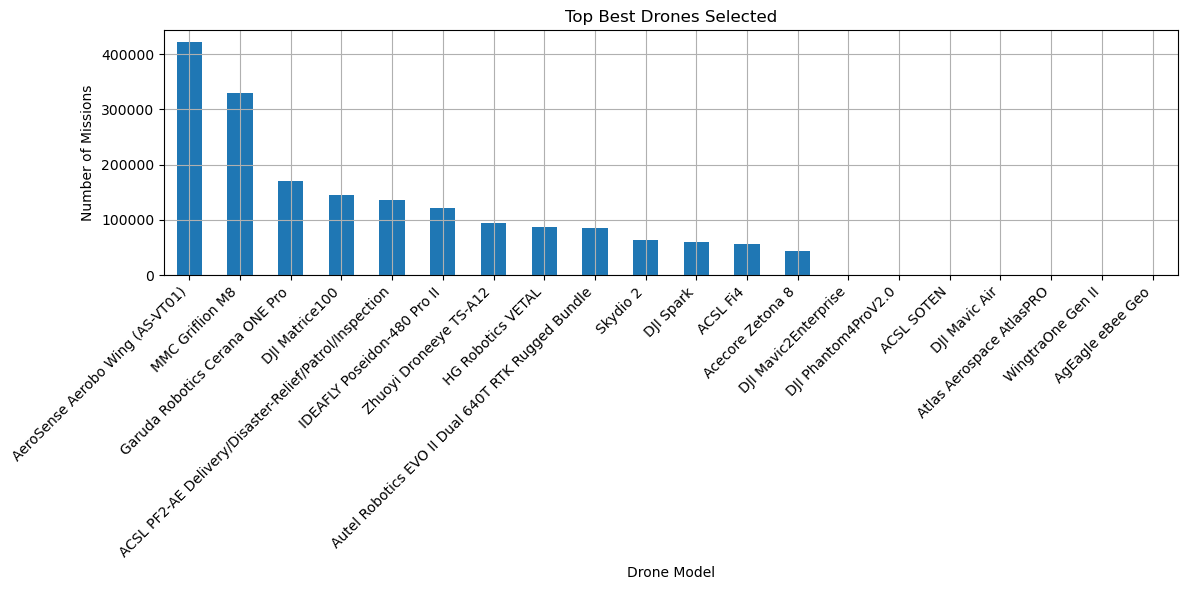

In [ ]:
best_counts = full_ghz_df['BestDrone_y'].value_counts()

plt.figure(figsize=(12,6))
best_counts.head(20).plot(kind='bar')
plt.title('Top Best Drones Selected')
plt.ylabel('Number of Missions')
plt.xlabel('Drone Model')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

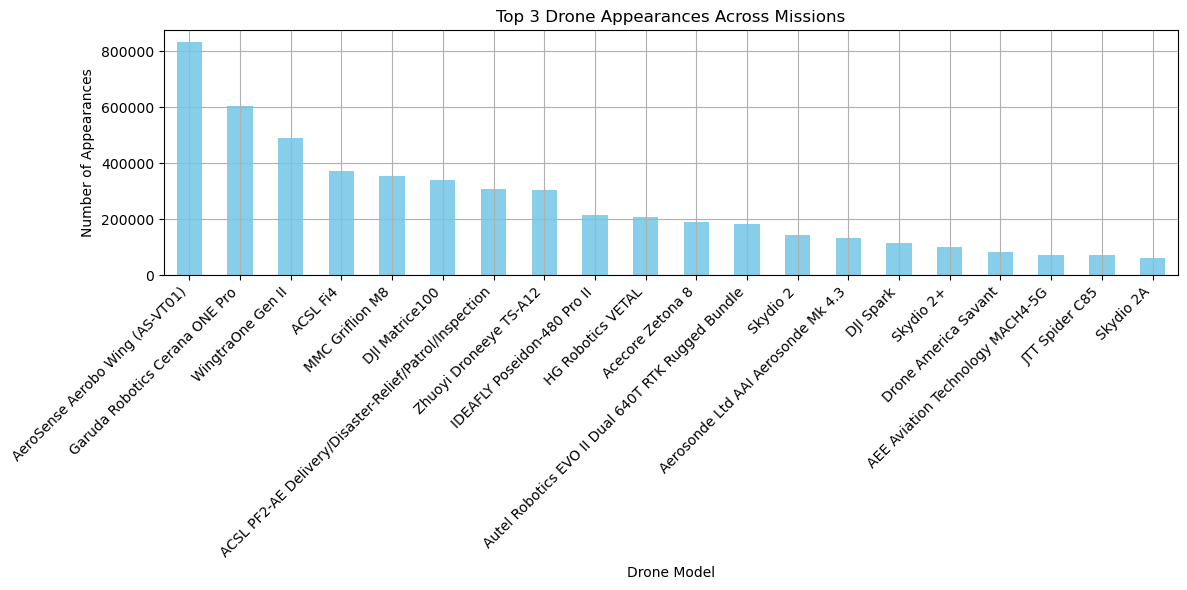

In [ ]:
# Split Top3Drones column into separate entries
top3_flat = full_ghz_df['Top3Drones_y'].dropna().str.split(', ').explode()

top3_counts = top3_flat.value_counts()

plt.figure(figsize=(12,6))
top3_counts.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 3 Drone Appearances Across Missions')
plt.ylabel('Number of Appearances')
plt.xlabel('Drone Model')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

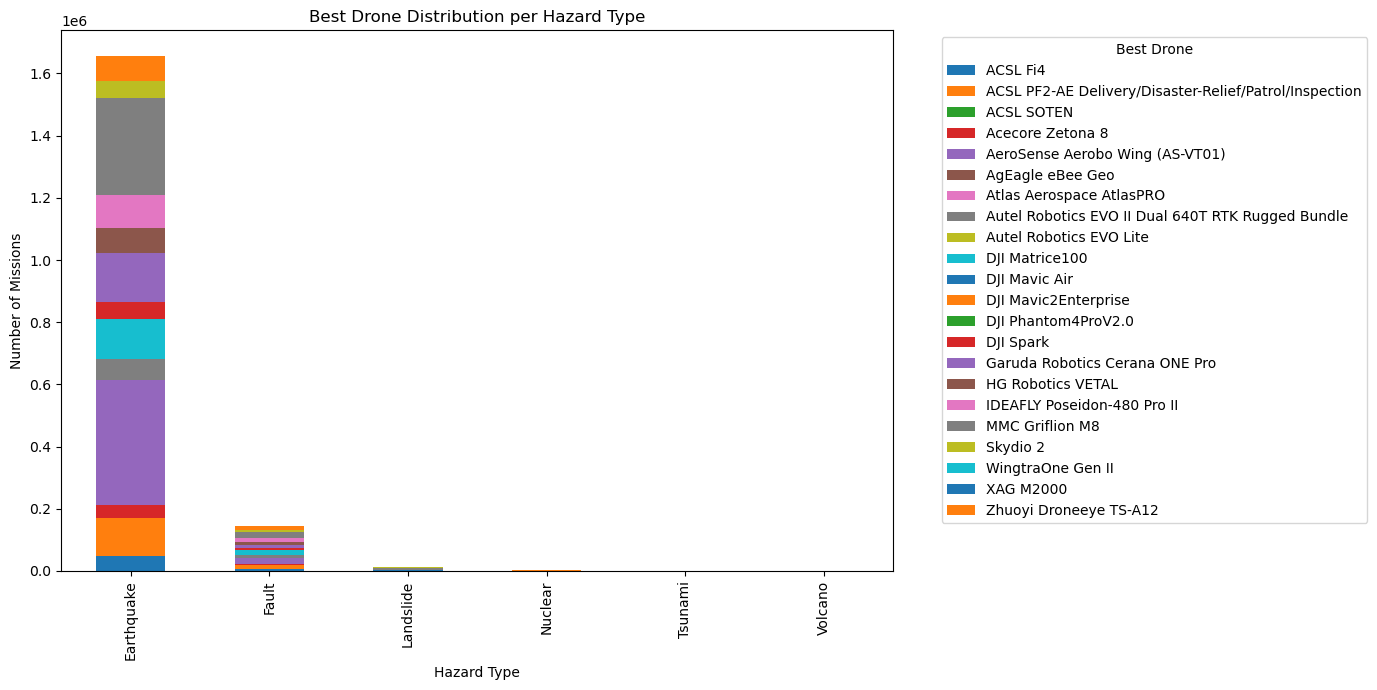

In [ ]:
pivot = (
    full_ghz_df
    .groupby(['HazardType', 'BestDrone_y'])
    .size()
    .unstack(fill_value=0)
)

pivot.plot(kind='bar', stacked=True, figsize=(14,7))
plt.title('Best Drone Distribution per Hazard Type')
plt.ylabel('Number of Missions')
plt.xlabel('Hazard Type')
plt.legend(title='Best Drone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816660 entries, 0 to 1816659
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  DroneSpeed_mps         float64
 16  distance_category      object 
 17  sensor_weight          int64  
 18  Top3Sensors            object 
dtypes: float64(11), int64(2), object(6)
memory usage: 263.3+ MB


In [ ]:
full_ghz_df['haz_stage_key'].unique()

array([('Volcano', 'during'), ('Volcano', 'pre_event'),
       ('Landslide', 'during'), ('Landslide', 'post_event'),
       ('Tsunami', 'during'), ('Earthquake', 'post_event'),
       ('Earthquake', 'during'), ('Fault', 'pre_event'),
       ('Nuclear', 'pre_event')], dtype=object)

In [ ]:
full_ghz_df = full_ghz_df.drop(columns=[
    'MatchedSensors', 'EligibleDrones', 'FilteredDrones',
    'BestDrone_x', 'BestDroneSpecs_x', 'Top3Drones_x', 'Top3Specs_x',
    'BestDrone_y', 'BestDroneSpecs_y', 'Top3Drones_y', 'Top3Specs_y',
    'key', 'PrimarySensor', 'PrimarySensorWeight', 'SelectedSensor'
])


---

# STAGGERED DECISION VERSION 2 - BALANCED DRONE BEST FIT WITH MATCHED TOP 3 SENSORS

---

# STEP 2: Top 3 Sensor Lookup (with Lidar substituted) --> Based on Scientometrics Method done

In [ ]:
top3_sensor_lookup = {
    'Earthquake': ['Seismic', 'Lidar', 'GPS'],
    'Volcano': ['Seismic', 'Lidar', 'Multispectral'],
    'Tsunami': ['Seismic', 'GPS', 'Multispectral'],
    'Landslide': ['Lidar', 'Seismic', 'Multispectral'],
    'Fault': ['Seismic', 'EM_Sensor', 'Gravimeter']
}


In [ ]:
full_ghz_df['Top3Sensors'] = full_ghz_df['HazardType'].map(top3_sensor_lookup)

In [ ]:
full_ghz_df['Top3Sensors']

0          [Seismic, Lidar, Multispectral]
1          [Seismic, Lidar, Multispectral]
2          [Seismic, Lidar, Multispectral]
3          [Seismic, Lidar, Multispectral]
4          [Seismic, Lidar, Multispectral]
                        ...               
1816655                                NaN
1816656                                NaN
1816657                                NaN
1816658                                NaN
1816659                                NaN
Name: Top3Sensors, Length: 1816660, dtype: object

In [ ]:
full_ghz_df['haz_stage_key']

0             (Volcano, during)
1             (Volcano, during)
2          (Volcano, pre_event)
3             (Volcano, during)
4          (Volcano, pre_event)
                   ...         
1816655    (Nuclear, pre_event)
1816656    (Nuclear, pre_event)
1816657    (Nuclear, pre_event)
1816658    (Nuclear, pre_event)
1816659    (Nuclear, pre_event)
Name: haz_stage_key, Length: 1816660, dtype: object

In [ ]:
missing_hazards = full_ghz_df[full_ghz_df['Top3Sensors'].isna()]['HazardType'].unique()
print("Missing hazard types:", missing_hazards)

Missing hazard types: ['Nuclear']


# STEP 3: Define the scoring function for Matching Sensors

In [ ]:
# Rebuild normalized_df from scientometrics counts
method_df = pd.DataFrame({
    'Geophysical Methods': [
        'Seismic', 'Radar', 'Remote Sensing', 'GPS', 'Imagery',
        'Electrical Resistivity', 'Gravity', 'Thermal', 'Electromagnetic', 'Magnetic'
    ],
    'Earthquake': [27136, 1762, 653, 712, 0, 0, 0, 0, 0, 0],
    'Volcano': [2493, 488, 375, 123, 173, 146, 106, 102, 88, 44],
    'Tsunami': [1137, 52, 58, 149, 0, 0, 0, 0, 0, 0],
    'Landslide': [756, 813, 673, 61, 468, 440, 0, 0, 31, 0],
    'Fault': [15686, 310, 363, 317, 0, 791, 461, 0, 343, 205],
    'Nuclear': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Placeholder if needed
})

normalized_df = method_df.copy()
for col in method_df.columns[1:]:
    max_val = method_df[col].max()
    normalized_df[col] = method_df[col] / max_val if max_val else 0


In [ ]:
# sensor_map must already exist
sensor_map = {
    'Seismic': 'Seismic',
    'Radar': 'Radarpod',
    'Remote Sensing': 'Multispectral',
    'GPS': 'GPS',
    'Imagery': 'Camera',
    'Electrical Resistivity': 'EM_Sensor',
    'Gravity': 'Gravimeter',
    'Thermal': 'Thermal_Camera',
    'Electromagnetic': 'EM_Sensor',
    'Magnetic': 'Magnetometers'
}

# Build (HazardType, Sensor) → Normalized Score from normalized_df
sensor_weight_lookup = {}

for _, row in normalized_df.iterrows():
    method = row['Geophysical Methods']
    sensor = sensor_map.get(method)
    if sensor:
        for hazard in normalized_df.columns[1:]:
            sensor_weight_lookup[(hazard, sensor)] = row[hazard]


In [ ]:
# Safe Top3 generator using SurveyOptions + scientometric weights
def generate_top3sensors_stage_aware(row):
    hazard = row['HazardType']
    options = row['SurveyOptions']

    if not isinstance(options, list) or len(options) == 0:
        return []

    scores = []
    for sensor in options:
        score = sensor_weight_lookup.get((hazard, sensor), 0)
        scores.append((sensor, score))

    top3 = [s[0] for s in sorted(scores, key=lambda x: x[1], reverse=True)[:3]]
    return top3

# Apply again
full_ghz_df['Top3Sensors'] = full_ghz_df.apply(generate_top3sensors_stage_aware, axis=1)


In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816660 entries, 0 to 1816659
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  DroneSpeed_mps         float64
 16  distance_category      object 
 17  sensor_weight          int64  
 18  Top3Sensors            object 
dtypes: float64(11), int64(2), object(6)
memory usage: 263.3+ MB


In [ ]:
print("\U0001f373 Processing chunk to ...")

🍳 Processing chunk to ...


In [ ]:
# Fast, chunked, vectorized staggered drone scorer per Top3Sensors
def batch_staggered_score(full_ghz_df, drone_df, sensor_df, chunk_size=50000):
    drone_df = drone_df[['mfc_model', 'max_payload_weight', 'distance_range']].dropna()
    sensor_df = sensor_df[['sensor_name', 'sensor_weight']].dropna()

    results = []

    for start in range(0, len(full_ghz_df), chunk_size):
        end = min(start + chunk_size, len(full_ghz_df))
        chunk = full_ghz_df.iloc[start:start+chunk_size].copy().reset_index(drop=True)
        print(f"\U0001f373 Processing chunk {start} to {end}...")  # <-- Sanity check line

        for sensor_col in ['s1', 's2', 's3']:
            sensor_array = chunk['Top3Sensors'].to_numpy(object)
            sensor_names = pd.Series([row[sensor_col_idx(sensor_col)] if isinstance(row, list) and len(row) > sensor_col_idx(sensor_col) else None for row in sensor_array], index=chunk.index)
            chunk[f'BestDrone_{sensor_col}'] = None

            for sensor_name in sensor_names.dropna().unique():
                sensor_weight = sensor_df[sensor_df['sensor_name'] == sensor_name]['sensor_weight'].values
                if len(sensor_weight) == 0:
                    continue
                sensor_weight = sensor_weight[0]

                # Subset of chunk using this sensor
                sub_idx = sensor_names[sensor_names == sensor_name].index
                sub_chunk = chunk.loc[sub_idx].copy()

                # Cross-join sub_chunk × drones
                sub_chunk['key'] = 1
                drone_df['key'] = 1
                merged = sub_chunk.merge(drone_df, on='key').drop(columns='key')

                h_dist = merged['distance']
                d_range = merged['distance_range']
                d_payload = merged['max_payload_weight']

                dist_score = (1 - abs(h_dist - d_range) / h_dist).clip(lower=0)
                payload_score = np.where(d_payload >= sensor_weight, 1, d_payload / sensor_weight)
                overkill_penalty = (np.maximum(0, d_payload - sensor_weight) / sensor_weight + np.maximum(0, d_range - h_dist) / h_dist) / 2
                tight_fit_bonus = np.where(d_payload >= sensor_weight, 1 - ((d_payload - sensor_weight) / d_payload), 0)

                score = 0.5 * dist_score + 0.4 * payload_score - 0.3 * overkill_penalty + 0.1 * tight_fit_bonus
                merged['final_score'] = score

                # Get best drone per HazardID
                best_per_hazard = (
                    merged.sort_values(['HazardID', 'final_score'], ascending=[True, False])
                    .groupby('HazardID').first()
                )

                # Map back best drone names to the main chunk
                # Join back using HazardID
                best_drone_map = best_per_hazard[['mfc_model']].reset_index()

                colname = f'BestDrone_{sensor_col}'
                if colname in chunk.columns:
                    chunk = chunk.drop(columns=[colname])
                chunk = chunk.merge(best_drone_map, on='HazardID', how='left')
                chunk.rename(columns={'mfc_model': colname}, inplace=True)

        results.append(chunk)

    return pd.concat(results, ignore_index=True)

def sensor_col_idx(col):
    return {'s1': 0, 's2': 1, 's3': 2}[col]


In [ ]:
start = timeit.default_timer()

full_ghz_df = batch_staggered_score(full_ghz_df, drone_df, sensor_df, chunk_size=50000)

elapsed = timeit.default_timer() - start
print(f"✅ Diverse Top-3 drones assigned! Time: {elapsed / 60:.2f} minutes")

🍳 Processing chunk 0 to 50000...
🍳 Processing chunk 50000 to 100000...
🍳 Processing chunk 100000 to 150000...
🍳 Processing chunk 150000 to 200000...
🍳 Processing chunk 200000 to 250000...
🍳 Processing chunk 250000 to 300000...
🍳 Processing chunk 300000 to 350000...
🍳 Processing chunk 350000 to 400000...
🍳 Processing chunk 400000 to 450000...
🍳 Processing chunk 450000 to 500000...
🍳 Processing chunk 500000 to 550000...
🍳 Processing chunk 550000 to 600000...
🍳 Processing chunk 600000 to 650000...
🍳 Processing chunk 650000 to 700000...
🍳 Processing chunk 700000 to 750000...
🍳 Processing chunk 750000 to 800000...
🍳 Processing chunk 800000 to 850000...
🍳 Processing chunk 850000 to 900000...
🍳 Processing chunk 900000 to 950000...
🍳 Processing chunk 950000 to 1000000...
🍳 Processing chunk 1000000 to 1050000...
🍳 Processing chunk 1050000 to 1100000...
🍳 Processing chunk 1100000 to 1150000...
🍳 Processing chunk 1150000 to 1200000...
🍳 Processing chunk 1200000 to 1250000...
🍳 Processing chunk 12

In [ ]:
full_ghz_df

,HazardID,latitude,longitude,HazardType,distance,pop,intensity,duration_minutes,economic_loss_million,travel_time,...,HazardStage,haz_stage_key,SurveyOptions,DroneSpeed_mps,distance_category,sensor_weight,Top3Sensors,BestDrone_s1,BestDrone_s2,BestDrone_s3
0,210010,50.1700,6.8500,Volcano,34.462092,1.346558e+05,2.0,1510.0,2.82,0.013054,...,during,"(Volcano, during)","[Thermal_Camera, Camera, Multispectral]",44.0,< 100m,830,"[Multispectral, Camera, Thermal_Camera]",NaN,NaN,Autel Robotics EVO II Dual 640T RTK Rugged Bundle
1,210020,45.7750,2.9700,Volcano,1068.063073,4.145101e+05,3.0,9376.0,9.86,0.404569,...,during,"(Volcano, during)","[Thermal_Camera, Camera, Multispectral]",44.0,500m–5km,830,"[Multispectral, Camera, Thermal_Camera]",NaN,NaN,IDEAFLY Poseidon-480 Pro II
2,210030,42.1700,2.5300,Volcano,1798.388196,1.461354e+05,1.0,33.0,0.51,0.681208,...,pre_event,"(Volcano, pre_event)","[Magnetometers, Seismic]",44.0,500m–5km,1000,"[Seismic, Magnetometers]",NaN,NaN,NaN
3,210040,38.8700,-4.0200,Volcano,547.012635,1.739199e+05,2.0,1672.0,2.62,0.207202,...,during,"(Volcano, during)","[Thermal_Camera, Camera, Multispectral]",44.0,500m–5km,830,"[Multispectral, Camera, Thermal_Camera]",NaN,NaN,ACSL Fi4
4,211004,41.7300,12.7000,Volcano,183.805721,2.411999e+06,1.0,151.0,0.99,0.069623,...,pre_event,"(Volcano, pre_event)","[Magnetometers, Seismic]",44.0,100m–500m,1000,"[Seismic, Magnetometers]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816655,111100000501492,11.4109,108.9743,Nuclear,253.455295,4.616941e+05,5.0,1440.0,0.00,0.096006,...,pre_event,"(Nuclear, pre_event)","[Thermal_Camera, Camera]",44.0,100m–500m,830,"[Thermal_Camera, Camera]",Zhuoyi Droneeye TS-A12,Zhuoyi Droneeye TS-A12,None
1816656,111100000501493,11.6903,109.1751,Nuclear,32.259321,4.522872e+05,5.0,1440.0,0.00,0.012219,...,pre_event,"(Nuclear, pre_event)","[Thermal_Camera, Camera]",44.0,< 100m,830,"[Thermal_Camera, Camera]",Autel Robotics EVO II Dual 640T RTK Rugged Bundle,Autel Robotics EVO II Dual 640T RTK Rugged Bundle,None
1816657,111100000501494,11.6903,109.1751,Nuclear,32.259321,4.522872e+05,5.0,1440.0,0.00,0.012219,...,pre_event,"(Nuclear, pre_event)","[Thermal_Camera, Camera]",44.0,< 100m,830,"[Thermal_Camera, Camera]",Autel Robotics EVO II Dual 640T RTK Rugged Bundle,Autel Robotics EVO II Dual 640T RTK Rugged Bundle,None
1816658,111100000501495,11.6903,109.1751,Nuclear,32.259321,4.522872e+05,5.0,1440.0,0.00,0.012219,...,pre_event,"(Nuclear, pre_event)","[Thermal_Camera, Camera]",44.0,< 100m,830,"[Thermal_Camera, Camera]",Autel Robotics EVO II Dual 640T RTK Rugged Bundle,Autel Robotics EVO II Dual 640T RTK Rugged Bundle,None


In [ ]:
full_ghz_df['BestDrone_s1'].unique()

array([nan, 'IDEAFLY Poseidon-480 Pro II', 'Zhuoyi Droneeye TS-A12',
       'Autel Robotics EVO II Dual 640T RTK Rugged Bundle',
       'DJI Matrice100', 'AeroSense Aerobo Wing (AS-VT01)', 'Skydio 2',
       'ACSL Fi4', 'DJI Spark', 'HG Robotics VETAL',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Garuda Robotics Cerana ONE Pro', 'MMC Griflion M8'], dtype=object)

In [ ]:
def batch_staggered_score(full_ghz_df, drone_df, sensor_df, chunk_size=50000):
    drone_df = drone_df[['mfc_model', 'max_payload_weight', 'distance_range']].dropna()
    sensor_df = sensor_df[['sensor_name', 'sensor_weight']].dropna()

    results = []

    def filter_drones_flexible(drones, hazard_distance, category):
        if category == "< 100m":
            threshold = 1.0
        elif category == "100m–500m":
            threshold = 0.8
        elif category == "500m–5km":
            threshold = 0.6
        elif category == "5km–50km":
            threshold = 0.4
        else:
            threshold = 0.0
        return drones[(drones['distance_range'] >= hazard_distance * threshold)]

    for start in range(0, len(full_ghz_df), chunk_size):
        end = min(start + chunk_size, len(full_ghz_df))
        print(f"\U0001f373 Processing chunk {start} to {end}...")
        chunk = full_ghz_df.iloc[start:end].copy().reset_index(drop=True)

        for sensor_col in ['s1', 's2', 's3']:
            sensor_array = chunk['Top3Sensors'].to_numpy(object)
            sensor_names = pd.Series(
                [row[sensor_col_idx(sensor_col)] if isinstance(row, list) and len(row) > sensor_col_idx(sensor_col) else None for row in sensor_array],
                index=chunk.index
            )
            chunk[f'BestDrone_{sensor_col}'] = None

            for sensor_name in sensor_names.dropna().unique():
                sensor_weight = sensor_df[sensor_df['sensor_name'] == sensor_name]['sensor_weight'].values
                if len(sensor_weight) == 0:
                    continue
                sensor_weight = sensor_weight[0]

                sub_idx = sensor_names[sensor_names == sensor_name].index
                sub_chunk = chunk.loc[sub_idx].copy()
                hazard_dist = sub_chunk['distance']
                hazard_cat = sub_chunk['distance_category']

                sub_chunk['key'] = 1
                drone_df['key'] = 1
                merged = sub_chunk.merge(drone_df, on='key').drop(columns='key')

                h_dist = merged['distance']
                d_range = merged['distance_range']
                d_payload = merged['max_payload_weight']

                dist_score = (1 - abs(h_dist - d_range) / h_dist).clip(lower=0)
                payload_score = np.where(d_payload >= sensor_weight, 1, d_payload / sensor_weight)
                overkill_penalty = (
                    (np.maximum(0, d_payload - sensor_weight) / sensor_weight +
                     np.maximum(0, d_range - h_dist) / h_dist) / 2
                )
                tight_fit_bonus = np.where(d_payload >= sensor_weight,
                                           1 - ((d_payload - sensor_weight) / d_payload), 0)

                score = (0.5 * dist_score +
                         0.4 * payload_score -
                         0.3 * overkill_penalty +
                         0.1 * tight_fit_bonus)

                merged['final_score'] = score

                if merged.empty:
                    fallback_drone = (
                        filter_drones_flexible(drone_df, hazard_dist.median(), hazard_cat.mode()[0])
                        .assign(score=np.abs(drone_df['max_payload_weight'] - sensor_weight))
                        .sort_values('score')
                    )
                    fallback = fallback_drone.iloc[0]['mfc_model'] if not fallback_drone.empty else None
                    chunk.loc[sub_idx, f'BestDrone_{sensor_col}'] = fallback
                    continue

                best_per_hazard = (
                    merged.sort_values(['HazardID', 'final_score'], ascending=[True, False])
                    .groupby('HazardID').first()
                )

                best_drone_map = best_per_hazard[['mfc_model']].reset_index()
                colname = f'BestDrone_{sensor_col}'
                if colname in chunk.columns:
                    chunk = chunk.drop(columns=[colname])
                chunk = chunk.merge(best_drone_map, on='HazardID', how='left')
                chunk.rename(columns={'mfc_model': colname}, inplace=True)

        results.append(chunk)

    return pd.concat(results, ignore_index=True)


In [ ]:
start = timeit.default_timer()

full_ghz_df = batch_staggered_score(full_ghz_df, drone_df, sensor_df, chunk_size=50000)

elapsed = timeit.default_timer() - start
print(f"\u2705 Diverse Top-3 drones assigned! Time: {elapsed / 60:.2f} minutes")

🍳 Processing chunk 0 to 50000...
🍳 Processing chunk 50000 to 100000...
🍳 Processing chunk 100000 to 150000...
🍳 Processing chunk 150000 to 200000...
🍳 Processing chunk 200000 to 250000...
🍳 Processing chunk 250000 to 300000...
🍳 Processing chunk 300000 to 350000...
🍳 Processing chunk 350000 to 400000...
🍳 Processing chunk 400000 to 450000...
🍳 Processing chunk 450000 to 500000...
🍳 Processing chunk 500000 to 550000...
🍳 Processing chunk 550000 to 600000...
🍳 Processing chunk 600000 to 650000...
🍳 Processing chunk 650000 to 700000...
🍳 Processing chunk 700000 to 750000...
🍳 Processing chunk 750000 to 800000...
🍳 Processing chunk 800000 to 850000...
🍳 Processing chunk 850000 to 900000...
🍳 Processing chunk 900000 to 950000...
🍳 Processing chunk 950000 to 1000000...
🍳 Processing chunk 1000000 to 1050000...
🍳 Processing chunk 1050000 to 1100000...
🍳 Processing chunk 1100000 to 1150000...
🍳 Processing chunk 1150000 to 1200000...
🍳 Processing chunk 1200000 to 1250000...
🍳 Processing chunk 12

In [ ]:
full_ghz_df.to_csv(r"D:\NDIS_Database\ghz_batchscore.csv", index=False)

In [ ]:
# Load geohazard dataset
full_ghz_df = pd.read_csv(r"D:\NDIS_Database\ghz_nuke.csv")
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816240 entries, 0 to 1816239
Data columns (total 26 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  MatchedSensors         object 
 16  EligibleDrones         object 
 17  FilteredDrones         object 
 18  BestDrone              object 
 19  BestDroneSpecs         object 
 20  DroneSpeed_mps         float64
 21  distance_category      object 
 22  sensor_weight     

In [ ]:
# Load Drone and Sensor data
drone_df = pd.read_csv("D:/NDIS_Database/rpas_nonan.csv") # Shortlisted verison of RPAS gdb with no NaN data on distance
sensor_df = pd.read_csv("D:/NDIS_Database/sensors.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_df.info()
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             71 non-null     int64  
 1   country             71 non-null     object 
 2   manufacturer        71 non-null     object 
 3   mfc_model           71 non-null     object 
 4   mtow                70 non-null     float64
 5   length              65 non-null     float64
 6   width               66 non-null     float64
 7   height              60 non-null     float64
 8   max_speed           69 non-null     float64
 9   distance_range      71 non-null     int64  
 10  flight_time         70 non-null     float64
 11  max_payload_weight  70 non-null     float64
 12  max_alt             47 non-null     float64
 13  comm_range          62 non-null     float64
 14  power_source        69 non-null     object 
 15  power               59 non-null     object 
 16  gps_accura

In [ ]:
cat3_summary

,mfc_model,distance_range,max_payload_weight
61,WingtraOne Gen II,50000,800.0
59,AeroSense Aerobo Wing (AS-VT01),50000,1000.0
55,Garuda Robotics Cerana ONE Pro,30240,1200.0
60,Doosan Mobility DS30W,50000,3000.0
56,DJI S900,35000,4700.0
50,ACSL AirTruck,20000,5000.0
58,Garuda Robotics Cerana X8,45000,8000.0
52,Dragandfly Innovations Inc Starling X.2,27000,10000.0
57,Freespace Operation Callisto 50 Multirotor,40000,25000.0
53,Dragandfly Innovations Inc Heavy Lift Drone,30000,30000.0


In [ ]:
mid_range_summary

,mfc_model,distance_range,max_payload_weight
31,DJI FPV,10000,0.0
48,DJI Mavic2Zoom,18000,0.0
47,DJI Mavic2Pro,18000,0.0
18,DJI Phantom4ProV2.0,7000,0.0
19,DJI Phantom4RTK,7000,0.0
20,DJI Inspire2,7000,0.0
26,DJI Mavic2EnterpriseDual,8000,0.0
30,DJI Mavic Air,10000,0.0
25,DJI Mavic2Enterprise,8000,0.0
35,ACSL SOTEN,12000,10.0


In [ ]:
full_ghz_df['BestDrone_s1'].unique()

array([nan, 'IDEAFLY Poseidon-480 Pro II', 'Zhuoyi Droneeye TS-A12',
       'Autel Robotics EVO II Dual 640T RTK Rugged Bundle',
       'DJI Matrice100', 'AeroSense Aerobo Wing (AS-VT01)', 'Skydio 2',
       'ACSL Fi4', 'DJI Spark', 'HG Robotics VETAL',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'Garuda Robotics Cerana ONE Pro', 'MMC Griflion M8'], dtype=object)

In [ ]:
cat1_summary

,drone_model,distance_range_m,payload_capacity_g
0,Autel Robotics EVO II Dual 640T RTK Rugged Bundle,21,0.0
1,Zhuoyi Droneeye TS-A12,300,0.0
2,ACSL Fi4,700,0.0
13,Parrot ANAFIAi,4000,0.0
11,DJI Mavic Mini,4000,0.0
5,DJI Spark,2000,0.0
10,Skydio 2A,3000,230.0
9,Skydio 2+,3000,230.0
8,Skydio 2,3000,230.0
16,AEE Aviation Technology MACH4-5G,5000,400.0


In [ ]:
# Count each category
distance_counts = full_ghz_df["distance_category"].value_counts().sort_index()

In [ ]:
distance_counts

distance_category
100m–500m    118052
500m–5km     393469
5km–50km     572928
< 100m        56343
> 50km       675868
Name: count, dtype: int64

In [ ]:
# Categorize drones by max distance
def categorize_drone_range(dist):
    if dist <= 1000:
        return "< 1km"
    elif dist <= 5000:
        return "1–5km"
    elif dist <= 20000:
        return "5–20km"
    elif dist <= 50000:
        return "20–50km"
    else:
        return "> 50km"

drone_df["distance_category"] = drone_df["distance_range"].apply(categorize_drone_range)

# Count per category
drone_distance_counts = drone_df["distance_category"].value_counts().sort_index()

In [ ]:
drone_distance_counts

distance_category
1–5km      13
20–50km    11
5–20km     33
< 1km       5
> 50km      9
Name: count, dtype: int64

In [ ]:
sensor_df

,sensor_id,parameters,sensor_name,s_encoded,sensor_weight
0,1,velocity,Seismic,1,1000
1,2,susceptibility,Magnetometers,2,1500
2,3,conductivity,EM_Sensor,3,3700
3,4,density,Gravimeter,4,50000
4,5,conductivity,GPR,5,3500
5,6,distance,Lidar,6,900
6,7,spectral,Camera,7,100
7,8,spectral,Hyperspectral,8,1900
8,9,spectral,Multispectral,9,350
9,10,temperature,Thermal_Camera,10,830


In [ ]:
# Categorize drones by max distance
def categorize_drone_weight(weight):
    if weight <= 500:
        return "< 500gr"
    elif weight <= 1000:
        return "500gr – 1kg"
    elif weight <= 2000:
        return "1–2kg"
    elif weight <= 5000:
        return "2–5kg"
    else:
        return "> 5kg"

drone_df["payloadweight_cat"] = drone_df["max_payload_weight"].apply(categorize_drone_weight)

# Count per category
drone_weight_counts = drone_df["payloadweight_cat"].value_counts().sort_index()
drone_weight_counts

payloadweight_cat
1–2kg           3
2–5kg          18
500gr – 1kg     5
< 500gr        28
> 5kg          17
Name: count, dtype: int64

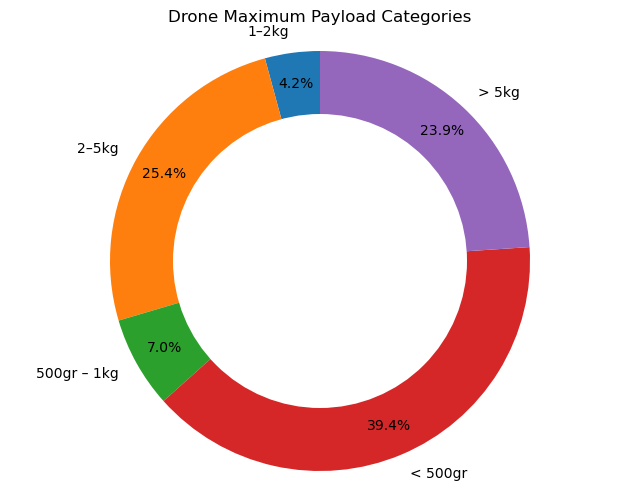

In [ ]:
# Plot donut
fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(
    drone_weight_counts,
    labels=drone_weight_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops=dict(width=0.4)
)

# Draw donut hole
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.title("Drone Maximum Payload Categories")
# Save the doughnut chart as a PNG image with high resolution

#plt.savefig(r'D:\NDIS_Database\dronedistance_distribution.png', dpi=300, transparent=True)

plt.show()

In [ ]:
full_ghz_df['Top3Sensors'] = full_ghz_df['Top3Sensors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [ ]:
print(full_ghz_df['Top3Sensors'].explode().unique())
print(sensor_df['sensor_name'].unique())

['Multispectral' 'Camera' 'Thermal_Camera' 'Seismic' 'Magnetometers'
 'Lidar']
['Seismic_Sensor' 'Magnetometers' 'EM_Sensor' 'Gravimeter' 'GPR_Sensor'
 'Lidar' 'Camera' 'Hyperspectral_sensors' 'Multispectral_sensors'
 'Thermal_Camera' 'Radarpod' 'BPR']


In [ ]:
sensor_weight_map = sensor_df.set_index('sensor_name')['sensor_weight'].to_dict()
sensor_weight_map.get("Camera")  # should return 100 or similar

100

In [ ]:
def simple_drone_selector(sensor_name, sensor_weight, hazard_distance, drone_df):
    if sensor_name == 'Camera':
        eligible = drone_df.copy()
    else:
        eligible = drone_df[drone_df['max_payload_weight'] >= sensor_weight]

    match = eligible[eligible['distance_range'] >= hazard_distance]
    if not match.empty:
        return match.sort_values(by=['max_payload_weight', 'distance_range']).iloc[0]['mfc_model']

    if not eligible.empty:
        fallback = eligible.copy()
        fallback['dist_diff'] = (fallback['distance_range'] - hazard_distance).abs()
        return fallback.sort_values(by='dist_diff').iloc[0]['mfc_model']

    return None


In [ ]:
def assign_best_drones_chunked(df, drone_df, sensor_df, chunk_size=50000):
    sensor_weight_map = sensor_df.set_index('sensor_name')['sensor_weight'].to_dict()
    results = []

    for start in range(0, len(df), chunk_size):
        end = min(start + chunk_size, len(df))
        print(f"\U0001f373 Processing chunk {start} to {end}...")
        chunk = df.iloc[start:end].copy()

        for i, sensor_pos in enumerate(['s1', 's2', 's3']):
            colname = f'BestDrone_{sensor_pos}'
            chunk[colname] = None

            for idx, row in chunk.iterrows():
                sensors = row['Top3Sensors']
                if not isinstance(sensors, list) or len(sensors) <= i:
                    continue

                sensor_name = sensors[i]
                sensor_weight = sensor_weight_map.get(sensor_name)
                if sensor_weight is None:
                    continue

                hazard_distance = row['distance']
                # print(f"{sensor_pos.upper()} | {sensor_name} | {sensor_weight}g | dist = {hazard_distance}")
                selected = simple_drone_selector(sensor_name, sensor_weight, hazard_distance, drone_df)
                chunk.at[idx, colname] = selected

        results.append(chunk)

    return pd.concat(results, ignore_index=True)


In [ ]:
full_ghz_df = assign_best_drones_chunked(full_ghz_df, drone_df, sensor_df)

🍳 Processing chunk 0 to 50000...
🍳 Processing chunk 50000 to 100000...
🍳 Processing chunk 100000 to 150000...
🍳 Processing chunk 150000 to 200000...
🍳 Processing chunk 200000 to 250000...
🍳 Processing chunk 250000 to 300000...
🍳 Processing chunk 300000 to 350000...
🍳 Processing chunk 350000 to 400000...
🍳 Processing chunk 400000 to 450000...
🍳 Processing chunk 450000 to 500000...
🍳 Processing chunk 500000 to 550000...
🍳 Processing chunk 550000 to 600000...
🍳 Processing chunk 600000 to 650000...
🍳 Processing chunk 650000 to 700000...
🍳 Processing chunk 700000 to 750000...
🍳 Processing chunk 750000 to 800000...
🍳 Processing chunk 800000 to 850000...
🍳 Processing chunk 850000 to 900000...
🍳 Processing chunk 900000 to 950000...
🍳 Processing chunk 950000 to 1000000...
🍳 Processing chunk 1000000 to 1050000...
🍳 Processing chunk 1050000 to 1100000...
🍳 Processing chunk 1100000 to 1150000...
🍳 Processing chunk 1150000 to 1200000...
🍳 Processing chunk 1200000 to 1250000...
🍳 Processing chunk 12

In [ ]:
full_ghz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816660 entries, 0 to 1816659
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   travel_time            float64
 10  monitor_time           float64
 11  cpm_total_time         float64
 12  HazardStage            object 
 13  haz_stage_key          object 
 14  SurveyOptions          object 
 15  DroneSpeed_mps         float64
 16  distance_category      object 
 17  sensor_weight          int64  
 18  Top3Sensors            object 
 19  BestDrone_s1           object 
 20  BestDrone_s2           object 
 21  BestDrone_s3           object 
dtypes: float64(11), in

In [ ]:
full_ghz_df['Top3Sensors'].isna().unique()

array([False])

In [ ]:
start = timeit.default_timer()

# Parse Top3Sensors
full_ghz_df['Top3Sensors'] = full_ghz_df['Top3Sensors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Extract first sensor
full_ghz_df['s1'] = full_ghz_df['Top3Sensors'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Map sensor weight
sensor_weight_map = sensor_df.set_index('sensor_name')['sensor_weight'].to_dict()
full_ghz_df['s1_weight'] = full_ghz_df['s1'].map(sensor_weight_map)

# Output column
full_ghz_df['BestDrone_s1'] = None

# Match sensor → drones by payload → then distance
for sensor in full_ghz_df['s1'].dropna().unique():
    w = sensor_weight_map.get(sensor, 0)
    sensor_mask = full_ghz_df['s1'] == sensor
    chunk = full_ghz_df[sensor_mask].copy()

    for idx, row in chunk.iterrows():
        hazard_distance = row['distance']

        # Step 1: payload match (or all drones for camera)
        if sensor == 'Camera':
            eligible = drone_df.copy()
        else:
            eligible = drone_df[drone_df['max_payload_weight'] >= w]

        # Step 2: match distance
        dist_match = eligible[eligible['distance_range'] >= hazard_distance]
        if not dist_match.empty:
            best = dist_match.sort_values(by=['max_payload_weight', 'distance_range']).iloc[0]['mfc_model']
        elif not eligible.empty:
            fallback = eligible.copy()
            fallback['dist_diff'] = (fallback['distance_range'] - hazard_distance).abs()
            best = fallback.sort_values(by='dist_diff').iloc[0]['mfc_model']
        else:
            best = None

        full_ghz_df.at[idx, 'BestDrone_s1'] = best


elapsed = timeit.default_timer() - start
print(f"\u2705 BestDrone for Sensor 1 is assigned! Time: {elapsed / 60:.2f} minutes")

# --- Ready for API --- ver 3.3.0

# STEP 1: Build Hazard-Stage-Survey Dictionary

In [ ]:
hazard_stage_survey_map = {
    ("Volcano", "pre_event"): ["Magnetometers", "Seismic", "Camera"],
    ("Volcano", "during"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Volcano", "post_event"): ["Lidar", "Camera", "Seismic"],
    ("Volcano", "clean_up"): ["Lidar", "Camera", "Seismic"],

    ("Earthquake", "pre_event"): ["Seismic", "Magnetometers", "Camera"],
    ("Earthquake", "during"): ["Seismic", "Camera", "Lidar"],
    ("Earthquake", "post_event"): ["Lidar", "Camera", "Seismic"],

    ("Fault", "pre_event"): ["Seismic", "Magnetometers", "Camera"],
    ("Fault", "post_event"): ["Seismic", "Camera", "Lidar"],

    ("Landslide", "pre_event"): ["Lidar", "GPR", "Camera"],
    ("Landslide", "during"): ["Camera", "Thermal_Camera", "Lidar"],
    ("Landslide", "post_event"): ["Lidar", "Seismic", "Camera"],
    ("Landslide", "clean_up"): ["Camera", "Lidar", "Seismic"],

    ("Tsunami", "during"): ["Camera", "Thermal_Camera", "Lidar"],
    ("Tsunami", "post_event"): ["Camera", "Lidar", "Seismic"],
    ("Tsunami", "clean_up"): ["Camera", "Lidar", "Seismic"],

    ("Nuclear", "pre_event"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Nuclear", "during"): ["Thermal_Camera", "Camera", "Lidar"],
    ("Nuclear", "post_event"): ["Camera", "Lidar", "Seismic"],
}

def get_top3_sensors_from_stage(stage_key):
    return hazard_stage_survey_map.get(stage_key, ["Seismic", "Camera", "Lidar"])


In [ ]:
sensor_weight_map = sensor_df.set_index('sensor_name')['sensor_weight'].to_dict()
sensor_weight_map.get("Camera")  # should return 100 or similar

100

In [ ]:
def fast_drone_match(sensor_name, hazard_distance, drone_df):
    sensor_weight = sensor_df[sensor_df['sensor_name'] == sensor_name]['sensor_weight']
    if sensor_weight.empty:
        return None
    sensor_weight = sensor_weight.values[0]

    # Step 1: Filter by payload
    eligible = drone_df[drone_df['max_payload_weight'] >= sensor_weight]

    # Step 2: Filter by flexible distance rule
    if hazard_distance < 100:
        threshold = 1.0
    elif hazard_distance < 500:
        threshold = 0.8
    elif hazard_distance < 5000:
        threshold = 0.6
    elif hazard_distance < 50000:
        threshold = 0.4
    else:
        threshold = 0.0  # Any drone OK

    eligible = eligible[
        (eligible['distance_range'] >= hazard_distance * threshold) |
        (hazard_distance > 50000)  # catch-all fallback
    ]

    if eligible.empty:
        # No match → fallback to closest by payload only
        fallback = drone_df[drone_df['max_payload_weight'] >= sensor_weight]
        if fallback.empty:
            return None
        return fallback.sort_values(by='max_payload_weight').iloc[0]

    # Return the closest fit by smallest "overkill"
    eligible['overkill'] = (eligible['max_payload_weight'] - sensor_weight).abs()
    return eligible.sort_values(by='overkill').iloc[0]


In [ ]:
def calculate_urgency(pop, intensity, econ_loss, distance):
    # Normalize each component to 0–1 scale
    norm_pop = min(pop / 1_000_000, 1.0)
    norm_intensity = min(intensity / 5, 1.0)
    norm_econ = min(econ_loss / 1000, 1.0)  # assume 1000M = extreme
    norm_dist = min(distance / 100_000, 1.0)  # cap at 100 km

    # Weighted combo (tweak as needed)
    raw_score = 0.4 * norm_pop + 0.3 * norm_intensity + 0.2 * norm_econ + 0.1 * norm_dist

    # Convert to 1–10 scale
    urgency_scaled = round(raw_score * 10)
    return min(max(urgency_scaled, 1), 10)


# Step 3: Mission Recommender

In [ ]:
def recommend_mission(
    lat: float,
    lon: float,
    radius: int = 10000,
    hazard_type: Optional[str] = None,
    sensors: Optional[List[str]] = None,
    stage: Optional[str] = None
):
    # 1. Find geohazards within buffer
    buffer_results = find_ghz_within_buffer(lat, lon, radius)
    if buffer_results.empty:
        return {"error": "No geohazards found in this radius."}

    # 2. Choose hazard (user-selected or highest intensity nearby)
    ghz_user = buffer_results[buffer_results['HazardType'] == hazard_type]
    if not ghz_user.empty:
        ghz = ghz_user.sort_values(by='intensity', ascending=False).iloc[0]
        alt_hazard = buffer_results['HazardType'].value_counts().idxmax()
        alt_note = None if alt_hazard == hazard_type else f"Note: This area shows more frequent {alt_hazard.lower()} hazards historically."
    else:
        ghz = buffer_results.sort_values(by='intensity', ascending=False).iloc[0]
        alt_note = f"No {hazard_type} found. Suggesting mission for nearby {ghz['HazardType'].lower()}."

    # 3. Determine Top3Sensors
    if sensors:
        top3_sensors = sensors[:3]
    else:
        stage_key = (ghz['HazardType'], stage or 'pre_event')
        top3_sensors = get_top3_sensors_from_stage(stage_key)

    # 4. Get sensor weights
    sensor_weights = [sensor_weight_map.get(s, 0) for s in top3_sensors]

    # 5. Find top 3 drones per sensor
    top3_drones = []
    for s_name, s_weight in zip(top3_sensors, sensor_weights):
        d = fast_drone_match(s_name, ghz['distance'], drone_df)
        if d is not None: top3_drones.append(d['mfc_model'])

    # 6. Select best drone + sensor combo
    best_pair = top3_drones[0] + " + " + top3_sensors[0] if top3_drones else None

    # 7. Get specs
    drone_specs = drone_df[drone_df['mfc_model'] == top3_drones[0]].iloc[0].to_dict() if top3_drones else {}

    # 8. Calculate CPM (travel + monitor time) → dummy for now
    mission_summary = {"travel_time_min": 12, "monitor_time_min": 18, "total_eta_min": 30}

    # 9. Urgency (population, intensity, economic loss, distance)
    urgency = calculate_urgency(
    ghz['pop'],
    ghz['intensity'],
    ghz['economic_loss_million'],
    ghz['distance']
)

    # 10. Logistics
    if ghz['distance'] > 50000:
        logistics = "BVLOS recommended. Ocean-capable or hybrid land-sea drone setup."
    elif ghz['distance'] > 20000:
        logistics = "Deploy from closest land vehicle, recommend long-range multirotor."
    else:
        logistics = "Standard RPAS deployment possible."

    return {
        "mission_summary": mission_summary,
        "top3_drones": top3_drones,
        "top3_sensors": top3_sensors,
        "best_pair": best_pair,
        "drone_specs": drone_specs,
        "urgency_score": urgency,
        "logistics_recommendation": logistics,
        "hazard_id": ghz['HazardID'],
        "hazard_type": ghz['HazardType'],
        "hazard_distance_m": ghz['distance'],
        "note": alt_note
    }


In [ ]:
def find_ghz_within_buffer(lat: float, lon: float, radius: float) -> pd.DataFrame:
    # Create GeoDataFrame of user point
    user_point = gpd.GeoDataFrame(
        geometry=[Point(lon, lat)],
        crs="EPSG:4326"  # global data is in WGS84
    ).to_crs(epsg=3857)  # Project to meters for buffer

    # Create a buffer around user point (radius in meters)
    buffer = user_point.buffer(radius).iloc[0]

    # Convert geohazard DataFrame to GeoDataFrame
    ghz_gdf = gpd.GeoDataFrame(
        full_ghz_df,
        geometry=gpd.points_from_xy(full_ghz_df.longitude, full_ghz_df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Filter points within buffer
    within = ghz_gdf[ghz_gdf.geometry.within(buffer)]

    return within.to_crs(epsg=4326).drop(columns="geometry")  # Convert back to WGS84

In [ ]:
start = timeit.default_timer()

# Example test
lat, lon = 49.3, -123.1  # or any valid coordinate
radius = 10000
hazard_type = "Volcano"
stage = "during"
sensors = None  # or manually pass e.g. ["Thermal_Camera", "Camera"]

result = recommend_mission(lat, lon, radius, hazard_type, sensors, stage)

elapsed = timeit.default_timer() - start
print(f"\u2705 Diverse Top-3 drones assigned! Time: {elapsed / 60:.2f} minutes")

pprint(result)

✅ Diverse Top-3 drones assigned! Time: 0.19 minutes
{'best_pair': 'Skydio 2 + Camera',
 'drone_specs': {'comm_range': 3000.0,
                 'configuration': '4',
                 'country': 'United States',
                 'def_payload': 'camera',
                 'distance_range': 3000,
                 'engine': 'BLDC',
                 'flight_cont': 'Autopilot',
                 'flight_time': 35.0,
                 'gps_accuracy': '50',
                 'height': 90.0,
                 'length': 290.0,
                 'manufacturer': 'Skydio',
                 'materials': 'Carbon Fiber Aluminum',
                 'max_alt': 100.0,
                 'max_op_temp': 40.0,
                 'max_payload_weight': 230.0,
                 'max_speed': 15.0,
                 'mfc_model': 'Skydio 2',
                 'min_op_temp': -20.0,
                 'mtow': 900.0,
                 'oas': 'Yes',
                 'power': '340000',
                 'power_source': 'battery',
      

# Statistics of Results

In [ ]:
# Define urgency score calculator
def calculate_urgency(pop, intensity, econ_loss, distance):
    norm_pop = np.minimum(pop / 1_000_000, 1.0)
    norm_intensity = np.minimum(intensity / 5, 1.0)
    norm_econ = np.minimum(econ_loss / 1000, 1.0)
    norm_dist = np.minimum(distance / 100_000, 1.0)
    raw_score = 0.4 * norm_pop + 0.3 * norm_intensity + 0.2 * norm_econ + 0.1 * norm_dist
    urgency_scaled = np.round(raw_score * 10)
    return np.clip(urgency_scaled, 1, 10)

# Top3 sensor selector
def get_top3_sensors_from_stage(stage_key):
    default = ["Camera", "Lidar", "Seismic"]
    return hazard_stage_survey_map.get(stage_key, default)

# Fast drone selector with fallback
def fast_drone_match(sensor_name, sensor_weight, hazard_distance, drone_df):
    subset = drone_df[drone_df['max_payload_weight'] >= sensor_weight]
    if sensor_name == "Camera":
        subset = pd.concat([subset, drone_df[drone_df['max_payload_weight'] == 0]])

    if subset.empty:
        return None

    subset['dist_diff'] = np.abs(subset['distance_range'] - hazard_distance)
    subset['weight_diff'] = subset['max_payload_weight'] - sensor_weight
    best = subset.sort_values(by=['dist_diff', 'weight_diff']).head(3)
    return best

# Main batch processor
def apply_recommender_batch(full_df, drone_df, sensor_df):
    records = []
    for _, row in full_df.iterrows():
        htype = row['HazardType']
        stage = row.get('HazardStage', 'pre_event')
        stage_key = (htype, stage)
        top3_sensors = get_top3_sensors_from_stage(stage_key)
        weights = [sensor_weight_map.get(s, 0) for s in top3_sensors]

        top3_drone_models = []
        for s, w in zip(top3_sensors, weights):
            top = fast_drone_match(s, w, row['distance'], drone_df)
            if top is not None:
                top3_drone_models.append(top.iloc[0]['mfc_model'])
            else:
                top3_drone_models.append(None)

        urgency = calculate_urgency(row['pop'], row['intensity'], row['economic_loss_million'], row['distance'])
        best_pair = f"{top3_drone_models[0]} + {top3_sensors[0]}" if top3_drone_models[0] else None
        records.append({
            'HazardID': row['HazardID'],
            'Top3Sensors': top3_sensors,
            'Top3Drones': top3_drone_models,
            'BestPair': best_pair,
            'UrgencyScore': urgency
        })

    return pd.DataFrame.from_records(records)

# Example chart after processing
def plot_drone_frequency(result_df):
    all_drones = pd.Series(sum(result_df['Top3Drones'].dropna().tolist(), []))
    counts = all_drones.value_counts().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    counts.head(20).plot(kind='bar')
    plt.title("Top 20 Drones Used Across All Hazards")
    plt.ylabel("Usage Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

In [ ]:
result_df = apply_recommender_batch(full_ghz_df, drone_df, sensor_df)

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.bar(models, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top Best Drones Selected')
plt.xlabel('Drone Model')
plt.ylabel('Number of Missions')
plt.tight_layout()
plt.show()